# Final Experiment (Pain Level Classification)

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scikitplot as skplt

from sklearn.model_selection import KFold
from sklearn.utils import compute_class_weight
from sklearn.metrics import balanced_accuracy_score
from tensorflow.keras.models import load_model
from pathlib import Path

import sys
module_path = os.path.abspath(os.getcwd() + '\\..')
if module_path not in sys.path:
    sys.path.append(module_path)
from src.data.load_dataset import load_dataset, load_fusioned_dataset, get_class_names
from src.lib.time_series_augmentation.utils.augmentation import jitter, rotation
from src.models.CNNLSTM import CNNLSTM
from src.models.CNNLSTMfusioned import CNNLSTM_fusioned
from src.models.RCNN import RCNN
from src.models.RCNNfusioned import RCNN_fusioned
from src.lib.DeepStack.deepstack.base import KerasMember
from src.lib.DeepStack.deepstack.ensemble import DirichletEnsemble

In [2]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
epochs = 100

cnnlstm_auc = []
rcnn_auc = []

In [3]:
model_path = Path(os.path.abspath('')).parent / 'models' / 'saved'

## 1. Unimodal Body (Skeleton Pose Estimation)

In [4]:
X_train, X_test, y_train, y_test = load_dataset('skeleton', level=True, nopain=False)
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

(380, 1, 350, 35) (380, 3)
(235, 1, 350, 35) (235, 3)


In [ ]:
extra_X_train, extra_X_test, extra_y_train, extra_y_test = load_dataset('skeleton', level=True, nopain=False, only_minority=True)
jitter_X = jitter(extra_X_train, sigma=0.03)
reshaped_X = extra_X_train.reshape((extra_X_train.shape[0], extra_X_train.shape[2], extra_X_train.shape[-1]))
rotated_X = rotation(reshaped_X)
rotated_X = rotated_X.reshape((rotated_X.shape[0], 1, rotated_X.shape[1], rotated_X.shape[-1]))
augmented_X = np.concatenate((rotated_X, jitter_X), axis=0)
add_y = np.concatenate((extra_y_train, extra_y_train), axis=0)
full_X = np.concatenate((augmented_X, X), axis=0)
full_y = np.concatenate((add_y, y), axis=0)
full_X.shape

In [5]:
classes = get_class_names('skeleton', level=True, nopain=False)
tmp = pd.DataFrame(classes)
classes = tmp.value_counts()
classes

Mild        219
Moderate    158
Severe        3
dtype: int64

In [6]:
y_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
d_class_weights = dict(enumerate(class_weights))
d_class_weights

{0: 0.578386605783866, 1: 0.8016877637130801, 2: 42.22222222222222}

### 1.1 CNN + BiLSTM

Epoch 1/100
11/11 - 24s - loss: 1.3071 - accuracy: 0.5088 - auc: 0.7419 - precision: 0.3333 - recall: 0.0029 - f1_score: 0.3374 - val_loss: 0.8712 - val_accuracy: 0.5526 - val_auc: 0.7493 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.2373 - 24s/epoch - 2s/step
Epoch 2/100
11/11 - 1s - loss: 1.1111 - accuracy: 0.5585 - auc: 0.8029 - precision: 1.0000 - recall: 0.0029 - f1_score: 0.3717 - val_loss: 0.8843 - val_accuracy: 0.5526 - val_auc: 0.7808 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.2373 - 1s/epoch - 126ms/step
Epoch 3/100
11/11 - 1s - loss: 1.0252 - accuracy: 0.6053 - auc: 0.8126 - precision: 0.8000 - recall: 0.0468 - f1_score: 0.4109 - val_loss: 0.8104 - val_accuracy: 0.5526 - val_auc: 0.7945 - val_precision: 0.5429 - val_recall: 0.5000 - val_f1_score: 0.2373 - 1s/epoch - 119ms/step
Epoch 4/100
11/11 - 1s - loss: 0.9494 - accuracy: 0.5965 - auc: 0.8270 - precision: 0.7831 - recall: 0.1901 - f1_score: 0.4396 - val_loss: 0.7671 - 

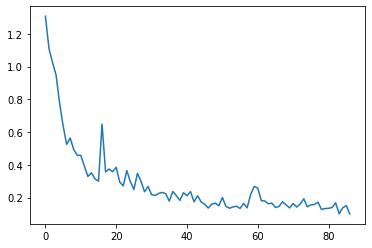

Epoch 1/100
11/11 - 9s - loss: 1.0298 - accuracy: 0.4737 - auc_1: 0.7301 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - f1_score: 0.3278 - val_loss: 0.9868 - val_accuracy: 0.4474 - val_auc_1: 0.7334 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_f1_score: 0.2061 - 9s/epoch - 846ms/step
Epoch 2/100
11/11 - 1s - loss: 0.9428 - accuracy: 0.6316 - auc_1: 0.8296 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - f1_score: 0.4139 - val_loss: 0.9469 - val_accuracy: 0.4474 - val_auc_1: 0.7029 - val_precision_1: 1.0000 - val_recall_1: 0.0263 - val_f1_score: 0.2061 - 1s/epoch - 119ms/step
Epoch 3/100
11/11 - 1s - loss: 0.9394 - accuracy: 0.6170 - auc_1: 0.8213 - precision_1: 0.7429 - recall_1: 0.0760 - f1_score: 0.4013 - val_loss: 0.9263 - val_accuracy: 0.4474 - val_auc_1: 0.7270 - val_precision_1: 1.0000 - val_recall_1: 0.0263 - val_f1_score: 0.2061 - 1s/epoch - 118ms/step
Epoch 4/100
11/11 - 1s - loss: 0.7572 - accuracy: 0.6901 - auc_1: 0.8449 - precision_1: 0.7667 - recall

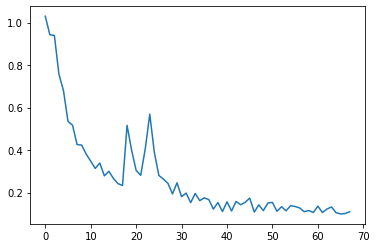

Epoch 1/100
11/11 - 9s - loss: 0.8088 - accuracy: 0.4181 - auc_2: 0.7099 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - f1_score: 0.2411 - val_loss: 0.8870 - val_accuracy: 0.5263 - val_auc_2: 0.7543 - val_precision_2: 0.5556 - val_recall_2: 0.1316 - val_f1_score: 0.2299 - 9s/epoch - 812ms/step
Epoch 2/100
11/11 - 1s - loss: 0.7653 - accuracy: 0.5906 - auc_2: 0.7983 - precision_2: 0.7593 - recall_2: 0.1199 - f1_score: 0.3943 - val_loss: 0.8605 - val_accuracy: 0.5263 - val_auc_2: 0.7469 - val_precision_2: 0.5263 - val_recall_2: 0.5263 - val_f1_score: 0.2299 - 1s/epoch - 119ms/step
Epoch 3/100
11/11 - 1s - loss: 0.8405 - accuracy: 0.6228 - auc_2: 0.8264 - precision_2: 0.6652 - recall_2: 0.4474 - f1_score: 0.4135 - val_loss: 0.8650 - val_accuracy: 0.5263 - val_auc_2: 0.7523 - val_precision_2: 0.5263 - val_recall_2: 0.5263 - val_f1_score: 0.2299 - 1s/epoch - 119ms/step
Epoch 4/100
11/11 - 1s - loss: 0.6170 - accuracy: 0.6930 - auc_2: 0.8613 - precision_2: 0.7441 - recall_2: 0.4591 - f1_

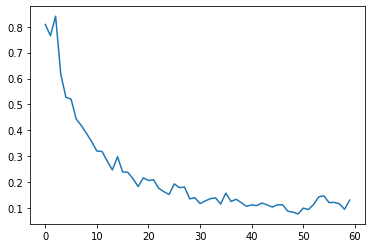

Epoch 1/100
11/11 - 9s - loss: 1.2326 - accuracy: 0.4094 - auc_3: 0.6876 - precision_3: 0.3333 - recall_3: 0.0029 - f1_score: 0.2484 - val_loss: 0.9477 - val_accuracy: 0.5526 - val_auc_3: 0.7684 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_f1_score: 0.2373 - 9s/epoch - 790ms/step
Epoch 2/100
11/11 - 1s - loss: 1.1172 - accuracy: 0.5936 - auc_3: 0.7967 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - f1_score: 0.3704 - val_loss: 0.9067 - val_accuracy: 0.5526 - val_auc_3: 0.7491 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_f1_score: 0.2373 - 1s/epoch - 119ms/step
Epoch 3/100
11/11 - 1s - loss: 1.0296 - accuracy: 0.5906 - auc_3: 0.7980 - precision_3: 0.6923 - recall_3: 0.0263 - f1_score: 0.4481 - val_loss: 0.8369 - val_accuracy: 0.5526 - val_auc_3: 0.7277 - val_precision_3: 0.3750 - val_recall_3: 0.1579 - val_f1_score: 0.2373 - 1s/epoch - 120ms/step
Epoch 4/100
11/11 - 1s - loss: 0.9200 - accuracy: 0.5585 - auc_3: 0.7717 - precision_3: 0.6875 - recall

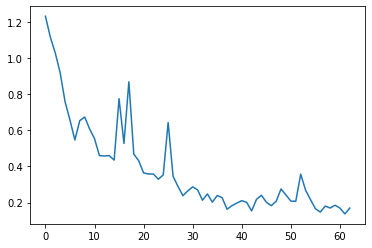

Epoch 1/100
11/11 - 9s - loss: 1.1880 - accuracy: 0.5175 - auc_4: 0.7527 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - f1_score: 0.2943 - val_loss: 0.9157 - val_accuracy: 0.3947 - val_auc_4: 0.7065 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_f1_score: 0.2263 - 9s/epoch - 808ms/step
Epoch 2/100
11/11 - 1s - loss: 1.1186 - accuracy: 0.5760 - auc_4: 0.7978 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - f1_score: 0.3671 - val_loss: 0.8934 - val_accuracy: 0.5000 - val_auc_4: 0.7173 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_f1_score: 0.3216 - 1s/epoch - 122ms/step
Epoch 3/100
11/11 - 1s - loss: 1.0281 - accuracy: 0.5731 - auc_4: 0.7882 - precision_4: 0.4286 - recall_4: 0.0088 - f1_score: 0.5479 - val_loss: 0.8669 - val_accuracy: 0.5526 - val_auc_4: 0.7675 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_f1_score: 0.2373 - 1s/epoch - 118ms/step
Epoch 4/100
11/11 - 1s - loss: 0.9378 - accuracy: 0.6053 - auc_4: 0.7975 - precision_4:

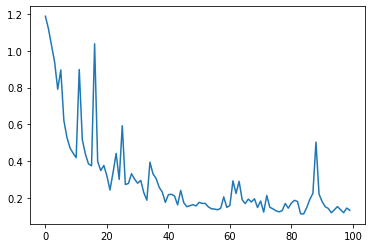

Epoch 1/100
11/11 - 8s - loss: 1.1774 - accuracy: 0.4649 - auc_5: 0.6738 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_score: 0.2695 - val_loss: 0.9097 - val_accuracy: 0.7105 - val_auc_5: 0.8218 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_score: 0.2769 - 8s/epoch - 769ms/step
Epoch 2/100
11/11 - 1s - loss: 1.1145 - accuracy: 0.6023 - auc_5: 0.8005 - precision_5: 1.0000 - recall_5: 0.0088 - f1_score: 0.4017 - val_loss: 0.8823 - val_accuracy: 0.7105 - val_auc_5: 0.8345 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_score: 0.2769 - 1s/epoch - 119ms/step
Epoch 3/100
11/11 - 1s - loss: 1.0271 - accuracy: 0.5556 - auc_5: 0.7753 - precision_5: 0.5000 - recall_5: 0.0058 - f1_score: 0.4441 - val_loss: 0.8238 - val_accuracy: 0.7105 - val_auc_5: 0.8160 - val_precision_5: 0.4545 - val_recall_5: 0.1316 - val_f1_score: 0.2769 - 1s/epoch - 119ms/step
Epoch 4/100
11/11 - 1s - loss: 0.9015 - accuracy: 0.6053 - auc_5: 0.8209 - precision_5: 0.6897 - recall

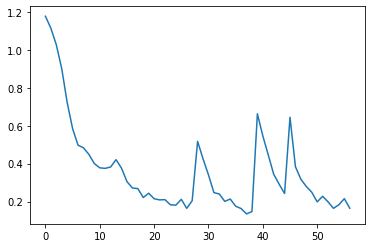

Epoch 1/100
11/11 - 8s - loss: 1.1623 - accuracy: 0.4532 - auc_6: 0.6996 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - f1_score: 0.3133 - val_loss: 0.9495 - val_accuracy: 0.4474 - val_auc_6: 0.7014 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00 - val_f1_score: 0.2302 - 8s/epoch - 770ms/step
Epoch 2/100
11/11 - 1s - loss: 1.1267 - accuracy: 0.5409 - auc_6: 0.7701 - precision_6: 0.6667 - recall_6: 0.0058 - f1_score: 0.3621 - val_loss: 0.9089 - val_accuracy: 0.5526 - val_auc_6: 0.7684 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00 - val_f1_score: 0.2373 - 1s/epoch - 120ms/step
Epoch 3/100
11/11 - 1s - loss: 0.9872 - accuracy: 0.6228 - auc_6: 0.8113 - precision_6: 0.6667 - recall_6: 0.0058 - f1_score: 0.4925 - val_loss: 0.8747 - val_accuracy: 0.5789 - val_auc_6: 0.7723 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00 - val_f1_score: 0.2444 - 1s/epoch - 119ms/step
Epoch 4/100
11/11 - 1s - loss: 0.9110 - accuracy: 0.6082 - auc_6: 0.7880 - precision_6: 0.5556 

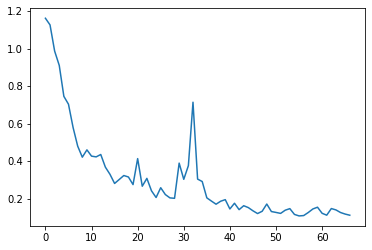

Epoch 1/100
11/11 - 8s - loss: 1.2513 - accuracy: 0.4854 - auc_7: 0.7443 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00 - f1_score: 0.3154 - val_loss: 0.9410 - val_accuracy: 0.6316 - val_auc_7: 0.7943 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00 - val_f1_score: 0.2581 - 8s/epoch - 769ms/step
Epoch 2/100
11/11 - 1s - loss: 1.1073 - accuracy: 0.5731 - auc_7: 0.7771 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00 - f1_score: 0.3806 - val_loss: 0.9596 - val_accuracy: 0.6316 - val_auc_7: 0.8009 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00 - val_f1_score: 0.2581 - 1s/epoch - 118ms/step
Epoch 3/100
11/11 - 1s - loss: 1.0619 - accuracy: 0.5789 - auc_7: 0.8110 - precision_7: 1.0000 - recall_7: 0.0088 - f1_score: 0.4814 - val_loss: 0.9581 - val_accuracy: 0.6316 - val_auc_7: 0.7928 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00 - val_f1_score: 0.2581 - 1s/epoch - 118ms/step
Epoch 4/100
11/11 - 1s - loss: 0.9268 - accuracy: 0.6140 - auc_7: 0.8201 - precision_7:

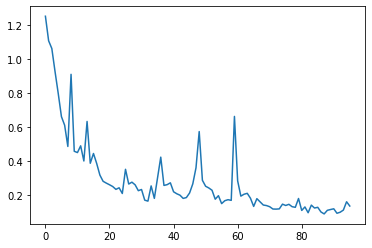

Epoch 1/100
11/11 - 8s - loss: 1.1522 - accuracy: 0.4152 - auc_8: 0.6230 - precision_8: 0.0000e+00 - recall_8: 0.0000e+00 - f1_score: 0.2250 - val_loss: 0.9893 - val_accuracy: 0.3421 - val_auc_8: 0.6236 - val_precision_8: 0.0000e+00 - val_recall_8: 0.0000e+00 - val_f1_score: 0.1699 - 8s/epoch - 765ms/step
Epoch 2/100
11/11 - 1s - loss: 1.1116 - accuracy: 0.4854 - auc_8: 0.7505 - precision_8: 1.0000 - recall_8: 0.0088 - f1_score: 0.3107 - val_loss: 0.8913 - val_accuracy: 0.4737 - val_auc_8: 0.7358 - val_precision_8: 0.0000e+00 - val_recall_8: 0.0000e+00 - val_f1_score: 0.2402 - 1s/epoch - 120ms/step
Epoch 3/100
11/11 - 1s - loss: 0.9535 - accuracy: 0.5497 - auc_8: 0.7720 - precision_8: 0.8571 - recall_8: 0.0175 - f1_score: 0.4421 - val_loss: 0.7797 - val_accuracy: 0.5526 - val_auc_8: 0.7791 - val_precision_8: 0.0000e+00 - val_recall_8: 0.0000e+00 - val_f1_score: 0.2373 - 1s/epoch - 119ms/step
Epoch 4/100
11/11 - 1s - loss: 0.8449 - accuracy: 0.6140 - auc_8: 0.8045 - precision_8: 0.7000 

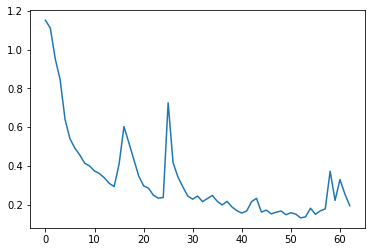

Epoch 1/100
11/11 - 8s - loss: 1.1761 - accuracy: 0.5117 - auc_9: 0.7475 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - f1_score: 0.3084 - val_loss: 0.9804 - val_accuracy: 0.5526 - val_auc_9: 0.7626 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00 - val_f1_score: 0.2373 - 8s/epoch - 758ms/step
Epoch 2/100
11/11 - 1s - loss: 1.0949 - accuracy: 0.5673 - auc_9: 0.7954 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - f1_score: 0.3538 - val_loss: 0.9368 - val_accuracy: 0.5526 - val_auc_9: 0.7607 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00 - val_f1_score: 0.2373 - 1s/epoch - 119ms/step
Epoch 3/100
11/11 - 1s - loss: 1.0293 - accuracy: 0.6520 - auc_9: 0.8212 - precision_9: 1.0000 - recall_9: 0.0058 - f1_score: 0.5150 - val_loss: 0.9046 - val_accuracy: 0.5526 - val_auc_9: 0.7870 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00 - val_f1_score: 0.2373 - 1s/epoch - 118ms/step
Epoch 4/100
11/11 - 1s - loss: 0.8872 - accuracy: 0.6199 - auc_9: 0.8260 - precision_9:

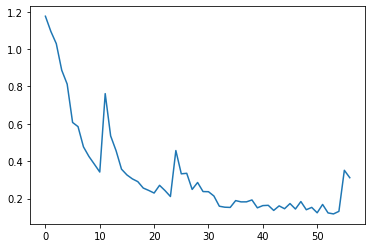

In [7]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []
val_accuracy = 0.0
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    cnnlstm_intensity_body_model = CNNLSTM(n_features, n_length, n_outputs, multiclass=True)
    history = cnnlstm_intensity_body_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=32, class_weight=d_class_weights)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        cnnlstm_intensity_body_model.save(model_path / 'body_intensity_cnnlstm.h5')

#### Training performance and variance

In [8]:
body_cnnlstm_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
body_cnnlstm_train_results

{'Accuracy': 0.9090643286705017,
 'ROC/AUC': 0.9838576257228852,
 'Precision': 0.9104778230190277,
 'Recall': 0.9081871330738067,
 'F1-score': 0.836544644832611}

In [9]:
body_cnnlstm_train_var = {'Accuracy': np.var(acc), 'ROC/AUC': np.var(auc), 'Precision': np.var(precision), 'Recall': np.var(recall), 'F1-score': np.var(f1)}
body_cnnlstm_train_var

{'Accuracy': 0.0009839782140916497,
 'ROC/AUC': 0.00016565347177138534,
 'Precision': 0.0008492801102949343,
 'Recall': 0.001045108755548121,
 'F1-score': 0.005418669575549586}

#### Validation performance

In [10]:
body_cnnlstm_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
body_cnnlstm_val_results

{'Accuracy': 0.5815789490938187,
 'ROC/AUC': 0.78602836728096,
 'Precision': 0.5802987188100814,
 'Recall': 0.5789473682641983,
 'F1-score': 0.3826039105653763}

In [11]:
body_cnnlstm_val_var = {'Accuracy': np.var(acc_val), 'ROC/AUC': np.var(auc_val), 'Precision': np.var(precision_val), 'Recall': np.var(recall_val), 'F1-score': np.var(f1_val)}
body_cnnlstm_val_var

{'Accuracy': 0.012112187324633802,
 'ROC/AUC': 0.004291406081155494,
 'Precision': 0.01226843732369546,
 'Recall': 0.012465373127414463,
 'F1-score': 0.005480663034471336}

#### Predictions and performance on test set

In [12]:
cnnlstm_intensity_body_model = load_model(model_path / 'body_intensity_cnnlstm.h5')
y_pred = cnnlstm_intensity_body_model.predict(X_test)
_, acc, auc, precision, recall, f1 = cnnlstm_intensity_body_model.evaluate(X_test, y_test)
bal_acc = balanced_accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))
cnnlstm_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

8/8 [==============================] - 2s 36ms/step - loss: 1.5284 - accuracy: 0.4851 - auc_4: 0.7462 - precision_4: 0.4872 - recall_4: 0.4851 - f1_score: 0.2712
Accuracy: 48.51% 
Balanced Accuracy: 27.42% 
ROC/AUC: 0.75 
Precision: 0.49 
Recall: 0.49 
F1 score: 0.27


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

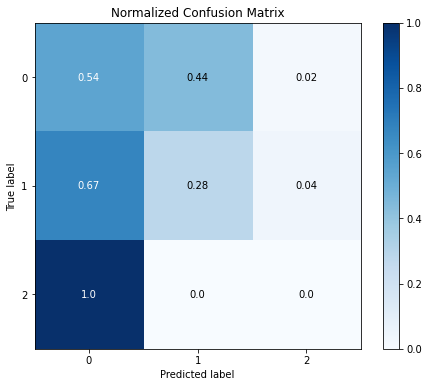

In [13]:
skplt.metrics.plot_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize=True, figsize=(8,6))

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

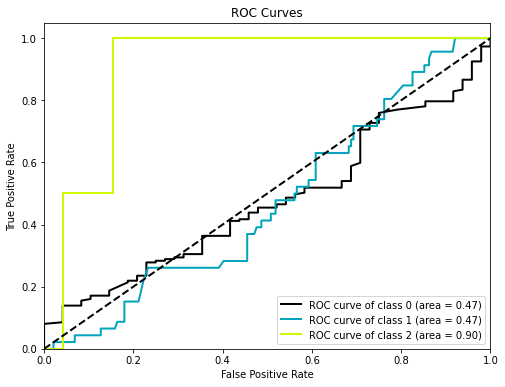

In [14]:
skplt.metrics.plot_roc(y_test.argmax(axis=1), y_pred, plot_micro=False, plot_macro=False, figsize=(8,6))

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

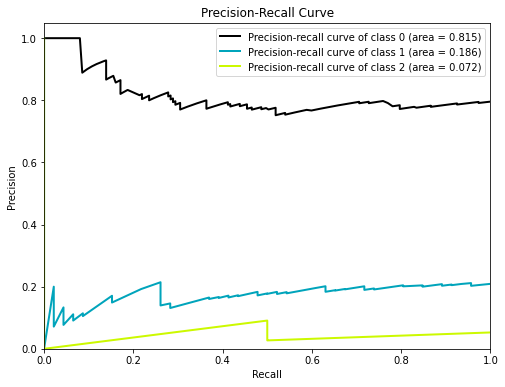

In [15]:
skplt.metrics.plot_precision_recall(y_test.argmax(axis=1), y_pred, plot_micro=False, figsize=(8,6))

### 1.2 RCNN

Epoch 1/100
11/11 - 3s - loss: 2.5085 - accuracy: 0.4737 - auc_10: 0.6893 - precision_10: 0.4766 - recall_10: 0.4474 - f1_score: 0.3443 - val_loss: 29.4296 - val_accuracy: 0.0000e+00 - val_auc_10: 0.2500 - val_precision_10: 0.0000e+00 - val_recall_10: 0.0000e+00 - val_f1_score: 0.0000e+00 - 3s/epoch - 247ms/step
Epoch 2/100
11/11 - 0s - loss: 1.0155 - accuracy: 0.4474 - auc_10: 0.6242 - precision_10: 0.4536 - recall_10: 0.3713 - f1_score: 0.3550 - val_loss: 3.6542 - val_accuracy: 0.5526 - val_auc_10: 0.6586 - val_precision_10: 0.5526 - val_recall_10: 0.5526 - val_f1_score: 0.2373 - 304ms/epoch - 28ms/step
Epoch 3/100
11/11 - 0s - loss: 0.6727 - accuracy: 0.5000 - auc_10: 0.7500 - precision_10: 0.5212 - recall_10: 0.4678 - f1_score: 0.3997 - val_loss: 1.7595 - val_accuracy: 0.4737 - val_auc_10: 0.7881 - val_precision_10: 0.4737 - val_recall_10: 0.4737 - val_f1_score: 0.2402 - 303ms/epoch - 28ms/step
Epoch 4/100
11/11 - 0s - loss: 0.6873 - accuracy: 0.5789 - auc_10: 0.7942 - precision_10

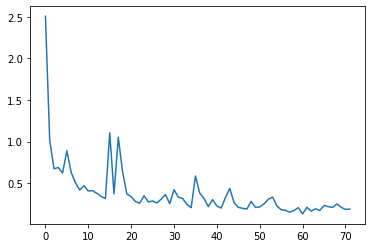

Epoch 1/100
11/11 - 3s - loss: 2.6234 - accuracy: 0.4766 - auc_11: 0.6864 - precision_11: 0.4850 - recall_11: 0.4269 - f1_score: 0.3312 - val_loss: 9.3459 - val_accuracy: 0.5263 - val_auc_11: 0.6447 - val_precision_11: 0.5263 - val_recall_11: 0.5263 - val_f1_score: 0.2299 - 3s/epoch - 249ms/step
Epoch 2/100
11/11 - 0s - loss: 0.7422 - accuracy: 0.5263 - auc_11: 0.7313 - precision_11: 0.5284 - recall_11: 0.4357 - f1_score: 0.3968 - val_loss: 4.0631 - val_accuracy: 0.4737 - val_auc_11: 0.7033 - val_precision_11: 0.4737 - val_recall_11: 0.4737 - val_f1_score: 0.2416 - 307ms/epoch - 28ms/step
Epoch 3/100
11/11 - 0s - loss: 0.6786 - accuracy: 0.5556 - auc_11: 0.7764 - precision_11: 0.5728 - recall_11: 0.5292 - f1_score: 0.4516 - val_loss: 5.1884 - val_accuracy: 0.4474 - val_auc_11: 0.6120 - val_precision_11: 0.4474 - val_recall_11: 0.4474 - val_f1_score: 0.2061 - 297ms/epoch - 27ms/step
Epoch 4/100
11/11 - 0s - loss: 0.5590 - accuracy: 0.5936 - auc_11: 0.8286 - precision_11: 0.6099 - recall

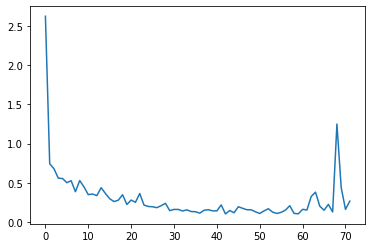

Epoch 1/100
11/11 - 3s - loss: 1.0856 - accuracy: 0.4591 - auc_12: 0.6571 - precision_12: 0.4679 - recall_12: 0.4474 - f1_score: 0.3161 - val_loss: 10.2027 - val_accuracy: 0.5263 - val_auc_12: 0.6447 - val_precision_12: 0.5263 - val_recall_12: 0.5263 - val_f1_score: 0.2299 - 3s/epoch - 235ms/step
Epoch 2/100
11/11 - 0s - loss: 0.7860 - accuracy: 0.5351 - auc_12: 0.7598 - precision_12: 0.5371 - recall_12: 0.5292 - f1_score: 0.3628 - val_loss: 7.8518 - val_accuracy: 0.5263 - val_auc_12: 0.6447 - val_precision_12: 0.5263 - val_recall_12: 0.5263 - val_f1_score: 0.2299 - 311ms/epoch - 28ms/step
Epoch 3/100
11/11 - 0s - loss: 0.5568 - accuracy: 0.6053 - auc_12: 0.8089 - precision_12: 0.6119 - recall_12: 0.5994 - f1_score: 0.4773 - val_loss: 4.8879 - val_accuracy: 0.4211 - val_auc_12: 0.6627 - val_precision_12: 0.4211 - val_recall_12: 0.4211 - val_f1_score: 0.2226 - 312ms/epoch - 28ms/step
Epoch 4/100
11/11 - 0s - loss: 0.4533 - accuracy: 0.6228 - auc_12: 0.8516 - precision_12: 0.6283 - recal

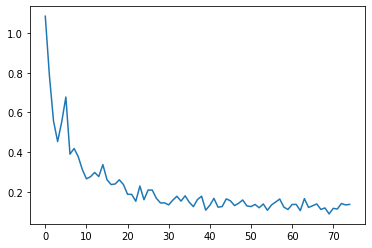

Epoch 1/100
11/11 - 3s - loss: 2.3887 - accuracy: 0.4532 - auc_13: 0.6734 - precision_13: 0.4581 - recall_13: 0.4152 - f1_score: 0.3318 - val_loss: 14.1411 - val_accuracy: 0.0000e+00 - val_auc_13: 0.2424 - val_precision_13: 0.0000e+00 - val_recall_13: 0.0000e+00 - val_f1_score: 0.0000e+00 - 3s/epoch - 249ms/step
Epoch 2/100
11/11 - 0s - loss: 0.9109 - accuracy: 0.5117 - auc_13: 0.7066 - precision_13: 0.5356 - recall_13: 0.4181 - f1_score: 0.3926 - val_loss: 1.5671 - val_accuracy: 0.5263 - val_auc_13: 0.7187 - val_precision_13: 0.5263 - val_recall_13: 0.5263 - val_f1_score: 0.3013 - 341ms/epoch - 31ms/step
Epoch 3/100
11/11 - 0s - loss: 1.0877 - accuracy: 0.4942 - auc_13: 0.7199 - precision_13: 0.5032 - recall_13: 0.4591 - f1_score: 0.3734 - val_loss: 3.6406 - val_accuracy: 0.5526 - val_auc_13: 0.6292 - val_precision_13: 0.5526 - val_recall_13: 0.5526 - val_f1_score: 0.2373 - 303ms/epoch - 28ms/step
Epoch 4/100
11/11 - 0s - loss: 0.6559 - accuracy: 0.5556 - auc_13: 0.7703 - precision_13

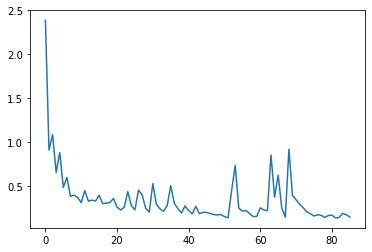

Epoch 1/100
11/11 - 3s - loss: 2.2562 - accuracy: 0.4006 - auc_14: 0.6160 - precision_14: 0.4019 - recall_14: 0.3655 - f1_score: 0.2948 - val_loss: 12.2181 - val_accuracy: 0.1579 - val_auc_14: 0.3179 - val_precision_14: 0.1579 - val_recall_14: 0.1579 - val_f1_score: 0.1290 - 3s/epoch - 260ms/step
Epoch 2/100
11/11 - 0s - loss: 1.0677 - accuracy: 0.4094 - auc_14: 0.6223 - precision_14: 0.4568 - recall_14: 0.3713 - f1_score: 0.3209 - val_loss: 8.8192 - val_accuracy: 0.4474 - val_auc_14: 0.5855 - val_precision_14: 0.4474 - val_recall_14: 0.4474 - val_f1_score: 0.2061 - 321ms/epoch - 29ms/step
Epoch 3/100
11/11 - 0s - loss: 0.9711 - accuracy: 0.4854 - auc_14: 0.7118 - precision_14: 0.5065 - recall_14: 0.4561 - f1_score: 0.3572 - val_loss: 1.6195 - val_accuracy: 0.4474 - val_auc_14: 0.6790 - val_precision_14: 0.4474 - val_recall_14: 0.4474 - val_f1_score: 0.2764 - 301ms/epoch - 27ms/step
Epoch 4/100
11/11 - 0s - loss: 0.6362 - accuracy: 0.5585 - auc_14: 0.7957 - precision_14: 0.5635 - recal

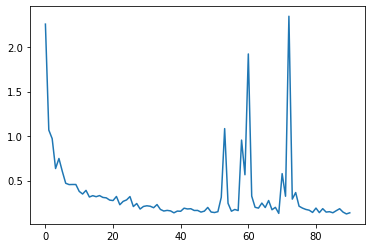

Epoch 1/100
11/11 - 3s - loss: 3.0291 - accuracy: 0.4386 - auc_15: 0.6348 - precision_15: 0.4365 - recall_15: 0.3918 - f1_score: 0.3143 - val_loss: 38.2752 - val_accuracy: 0.0000e+00 - val_auc_15: 0.2107 - val_precision_15: 0.0000e+00 - val_recall_15: 0.0000e+00 - val_f1_score: 0.0000e+00 - 3s/epoch - 263ms/step
Epoch 2/100
11/11 - 0s - loss: 1.0066 - accuracy: 0.4825 - auc_15: 0.6684 - precision_15: 0.4899 - recall_15: 0.4269 - f1_score: 0.3699 - val_loss: 36.5124 - val_accuracy: 0.0000e+00 - val_auc_15: 0.2500 - val_precision_15: 0.0000e+00 - val_recall_15: 0.0000e+00 - val_f1_score: 0.0000e+00 - 324ms/epoch - 29ms/step
Epoch 3/100
11/11 - 0s - loss: 1.4961 - accuracy: 0.3743 - auc_15: 0.5846 - precision_15: 0.3713 - recall_15: 0.3333 - f1_score: 0.3003 - val_loss: 13.4276 - val_accuracy: 0.1053 - val_auc_15: 0.3149 - val_precision_15: 0.1053 - val_recall_15: 0.1053 - val_f1_score: 0.0808 - 316ms/epoch - 29ms/step
Epoch 4/100
11/11 - 0s - loss: 0.6523 - accuracy: 0.5906 - auc_15: 0.7

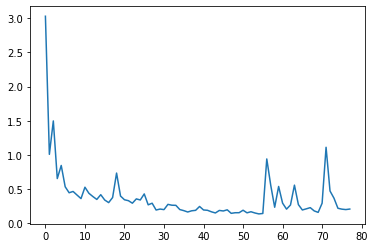

Epoch 1/100
11/11 - 3s - loss: 2.2447 - accuracy: 0.3830 - auc_16: 0.5932 - precision_16: 0.3856 - recall_16: 0.3450 - f1_score: 0.2877 - val_loss: 10.7411 - val_accuracy: 0.5789 - val_auc_16: 0.6842 - val_precision_16: 0.5789 - val_recall_16: 0.5789 - val_f1_score: 0.2444 - 3s/epoch - 233ms/step
Epoch 2/100
11/11 - 0s - loss: 1.1281 - accuracy: 0.4240 - auc_16: 0.6422 - precision_16: 0.4457 - recall_16: 0.3596 - f1_score: 0.3337 - val_loss: 6.0363 - val_accuracy: 0.0263 - val_auc_16: 0.2929 - val_precision_16: 0.0263 - val_recall_16: 0.0263 - val_f1_score: 0.0267 - 307ms/epoch - 28ms/step
Epoch 3/100
11/11 - 0s - loss: 1.0022 - accuracy: 0.4678 - auc_16: 0.6777 - precision_16: 0.4811 - recall_16: 0.4094 - f1_score: 0.3663 - val_loss: 4.9363 - val_accuracy: 0.5263 - val_auc_16: 0.5864 - val_precision_16: 0.5263 - val_recall_16: 0.5263 - val_f1_score: 0.2516 - 304ms/epoch - 28ms/step
Epoch 4/100
11/11 - 0s - loss: 0.5769 - accuracy: 0.5819 - auc_16: 0.8018 - precision_16: 0.6093 - recal

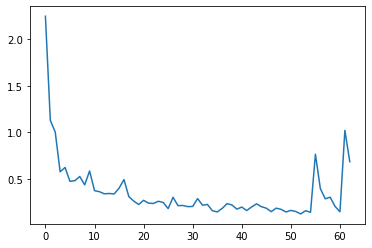

Epoch 1/100
11/11 - 3s - loss: 2.9477 - accuracy: 0.3947 - auc_17: 0.5724 - precision_17: 0.3875 - recall_17: 0.3275 - f1_score: 0.3097 - val_loss: 2.1920 - val_accuracy: 0.4211 - val_auc_17: 0.6641 - val_precision_17: 0.4211 - val_recall_17: 0.4211 - val_f1_score: 0.2520 - 3s/epoch - 273ms/step
Epoch 2/100
11/11 - 0s - loss: 1.1911 - accuracy: 0.4795 - auc_17: 0.6723 - precision_17: 0.4931 - recall_17: 0.4181 - f1_score: 0.3628 - val_loss: 3.8004 - val_accuracy: 0.2368 - val_auc_17: 0.3483 - val_precision_17: 0.2162 - val_recall_17: 0.2105 - val_f1_score: 0.1920 - 288ms/epoch - 26ms/step
Epoch 3/100
11/11 - 0s - loss: 0.6257 - accuracy: 0.5760 - auc_17: 0.7888 - precision_17: 0.6090 - recall_17: 0.5146 - f1_score: 0.4488 - val_loss: 1.2949 - val_accuracy: 0.4737 - val_auc_17: 0.7039 - val_precision_17: 0.4737 - val_recall_17: 0.4737 - val_f1_score: 0.2995 - 282ms/epoch - 26ms/step
Epoch 4/100
11/11 - 0s - loss: 0.9535 - accuracy: 0.4386 - auc_17: 0.6733 - precision_17: 0.4485 - recall

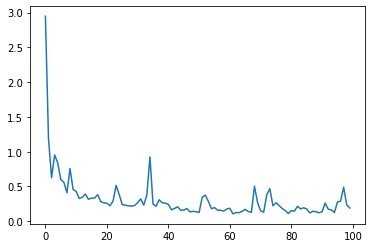

Epoch 1/100
11/11 - 2s - loss: 2.4726 - accuracy: 0.2281 - auc_18: 0.4691 - precision_18: 0.2543 - recall_18: 0.2164 - f1_score: 0.1939 - val_loss: 18.3855 - val_accuracy: 0.0000e+00 - val_auc_18: 0.2632 - val_precision_18: 0.0000e+00 - val_recall_18: 0.0000e+00 - val_f1_score: 0.0000e+00 - 2s/epoch - 223ms/step
Epoch 2/100
11/11 - 0s - loss: 1.0847 - accuracy: 0.4035 - auc_18: 0.6377 - precision_18: 0.4085 - recall_18: 0.3655 - f1_score: 0.3110 - val_loss: 49.8701 - val_accuracy: 0.0000e+00 - val_auc_18: 0.2500 - val_precision_18: 0.0000e+00 - val_recall_18: 0.0000e+00 - val_f1_score: 0.0000e+00 - 272ms/epoch - 25ms/step
Epoch 3/100
11/11 - 0s - loss: 0.7758 - accuracy: 0.4795 - auc_18: 0.6976 - precision_18: 0.4983 - recall_18: 0.4327 - f1_score: 0.3771 - val_loss: 3.1463 - val_accuracy: 0.5789 - val_auc_18: 0.6835 - val_precision_18: 0.5789 - val_recall_18: 0.5789 - val_f1_score: 0.2529 - 277ms/epoch - 25ms/step
Epoch 4/100
11/11 - 0s - loss: 0.9417 - accuracy: 0.5234 - auc_18: 0.74

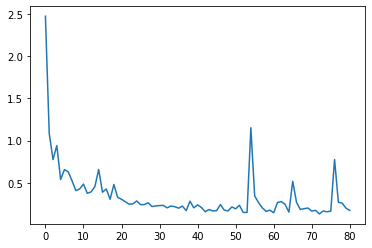

Epoch 1/100
11/11 - 2s - loss: 2.9816 - accuracy: 0.4094 - auc_19: 0.6294 - precision_19: 0.4290 - recall_19: 0.3801 - f1_score: 0.3114 - val_loss: 4.5895 - val_accuracy: 0.5526 - val_auc_19: 0.6721 - val_precision_19: 0.5526 - val_recall_19: 0.5526 - val_f1_score: 0.2373 - 2s/epoch - 225ms/step
Epoch 2/100
11/11 - 0s - loss: 1.3637 - accuracy: 0.3743 - auc_19: 0.5832 - precision_19: 0.3877 - recall_19: 0.3129 - f1_score: 0.2864 - val_loss: 1.7207 - val_accuracy: 0.5263 - val_auc_19: 0.7375 - val_precision_19: 0.5263 - val_recall_19: 0.5263 - val_f1_score: 0.2299 - 282ms/epoch - 26ms/step
Epoch 3/100
11/11 - 0s - loss: 0.6829 - accuracy: 0.5877 - auc_19: 0.7734 - precision_19: 0.6087 - recall_19: 0.5322 - f1_score: 0.4523 - val_loss: 3.6715 - val_accuracy: 0.4474 - val_auc_19: 0.6285 - val_precision_19: 0.4474 - val_recall_19: 0.4474 - val_f1_score: 0.2061 - 275ms/epoch - 25ms/step
Epoch 4/100
11/11 - 0s - loss: 0.5540 - accuracy: 0.5994 - auc_19: 0.8209 - precision_19: 0.6068 - recall

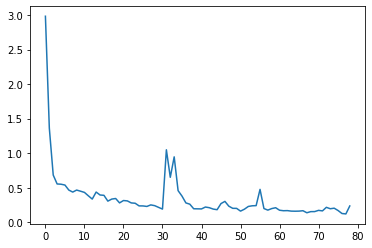

In [16]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []
val_accuracy = 0.0
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    rcnn_intensity_body_model = RCNN(n_features, n_length, n_outputs, multiclass=True)
    history = rcnn_intensity_body_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=32, class_weight=d_class_weights)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        rcnn_intensity_body_model.save(model_path / 'body_intensity_rcnn.h5')

#### Training performance

In [17]:
body_rcnn_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
body_rcnn_train_results

{'Accuracy': 0.9084795355796814,
 'ROC/AUC': 0.9748001396656036,
 'Precision': 0.9089302837848663,
 'Recall': 0.907894742488861,
 'F1-score': 0.8345342576503754}

In [18]:
body_rcnn_train_var = {'Accuracy': np.var(acc), 'ROC/AUC': np.var(auc), 'Precision': np.var(precision), 'Recall': np.var(recall), 'F1-score': np.var(f1)}
body_rcnn_train_var

{'Accuracy': 0.0011765160979622636,
 'ROC/AUC': 0.0003740242700340346,
 'Precision': 0.0011619502804933646,
 'Recall': 0.0012076366657494475,
 'F1-score': 0.006362721314472175}

#### Validation performance

In [19]:
body_rcnn_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
body_rcnn_val_results

{'Accuracy': 0.6421052575111389,
 'ROC/AUC': 0.8130020678043366,
 'Precision': 0.6436699807643891,
 'Recall': 0.6421052575111389,
 'F1-score': 0.4141662895679474}

In [20]:
body_rcnn_val_var = {'Accuracy': np.var(acc_val), 'ROC/AUC': np.var(auc_val), 'Precision': np.var(precision_val), 'Recall': np.var(recall_val), 'F1-score': np.var(f1_val)}
body_rcnn_val_var

{'Accuracy': 0.008060941187629,
 'ROC/AUC': 0.002732389405613169,
 'Precision': 0.00788532717217411,
 'Recall': 0.008060941187629,
 'F1-score': 0.0036513783298812185}

#### Predictions and performance on test set

In [21]:
rcnn_intensity_body_model = load_model(model_path / 'body_intensity_rcnn.h5')
y_pred = rcnn_intensity_body_model.predict(X_test)
_, acc, auc, precision, recall, f1 = rcnn_intensity_body_model.evaluate(X_test, y_test)
bal_acc = balanced_accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))
rcnn_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

8/8 [==============================] - 0s 8ms/step - loss: 1.0865 - accuracy: 0.5532 - auc_10: 0.7763 - precision_10: 0.5565 - recall_10: 0.5447 - f1_score: 0.3182
Accuracy: 55.32% 
Balanced Accuracy: 33.55% 
ROC/AUC: 0.78 
Precision: 0.56 
Recall: 0.54 
F1 score: 0.32


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

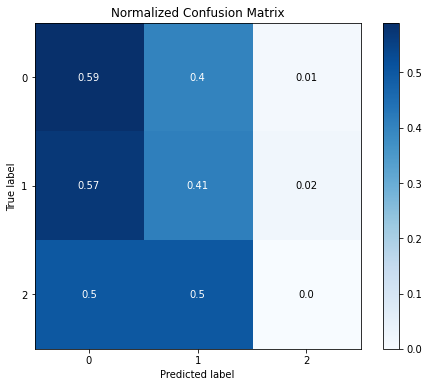

In [22]:
skplt.metrics.plot_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize=True, figsize=(8,6))

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

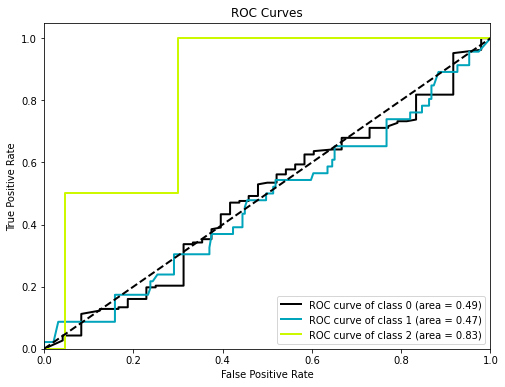

In [23]:
skplt.metrics.plot_roc(y_test.argmax(axis=1), y_pred, plot_micro=False, plot_macro=False, figsize=(8,6))

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

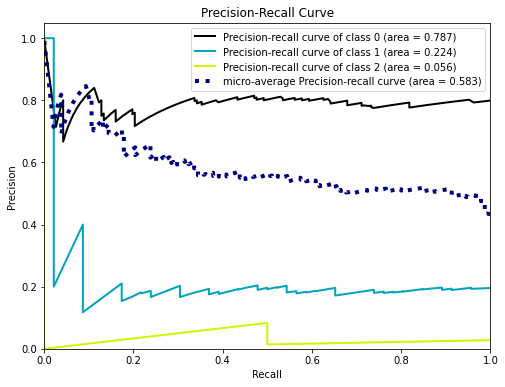

In [24]:
skplt.metrics.plot_precision_recall_curve(y_test.argmax(axis=1), y_pred, figsize=(8,6))

## 2. Unimodal Face (Facial Expression + Head Pose)

In [25]:
X_train, X_test, y_train, y_test = load_dataset('AUs', level=True, nopain=False)
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

(366, 1, 350, 25) (366, 3)
(231, 1, 350, 25) (231, 3)


In [26]:
classes = get_class_names('AUs', level=True, nopain=False)
tmp = pd.DataFrame(classes)
classes = tmp.value_counts()
classes

Mild        211
Moderate    152
Severe        3
dtype: int64

In [27]:
y_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
d_class_weights = dict(enumerate(class_weights))
d_class_weights

{0: 0.5781990521327014, 1: 0.8026315789473685, 2: 40.666666666666664}

### 2.1 CNN + BiLSTM

Epoch 1/100
11/11 - 8s - loss: 1.0095 - accuracy: 0.5502 - auc_20: 0.7716 - precision_20: 0.0000e+00 - recall_20: 0.0000e+00 - f1_score: 0.2822 - val_loss: 0.9794 - val_accuracy: 0.4595 - val_auc_20: 0.6901 - val_precision_20: 0.0000e+00 - val_recall_20: 0.0000e+00 - val_f1_score: 0.2099 - 8s/epoch - 759ms/step
Epoch 2/100
11/11 - 1s - loss: 0.9936 - accuracy: 0.6018 - auc_20: 0.7988 - precision_20: 0.6136 - recall_20: 0.0821 - f1_score: 0.3199 - val_loss: 0.9937 - val_accuracy: 0.3243 - val_auc_20: 0.6899 - val_precision_20: 0.0000e+00 - val_recall_20: 0.0000e+00 - val_f1_score: 0.1841 - 1s/epoch - 106ms/step
Epoch 3/100
11/11 - 1s - loss: 0.9911 - accuracy: 0.5471 - auc_20: 0.7863 - precision_20: 0.6842 - recall_20: 0.0395 - f1_score: 0.3581 - val_loss: 1.0320 - val_accuracy: 0.4865 - val_auc_20: 0.7051 - val_precision_20: 0.0000e+00 - val_recall_20: 0.0000e+00 - val_f1_score: 0.3194 - 1s/epoch - 107ms/step
Epoch 4/100
11/11 - 1s - loss: 0.9321 - accuracy: 0.5836 - auc_20: 0.8062 - p

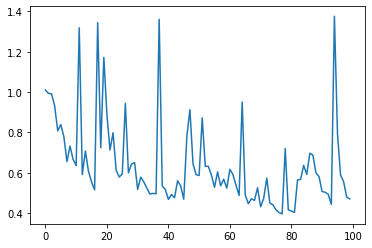

Epoch 1/100
11/11 - 8s - loss: 1.1796 - accuracy: 0.4407 - auc_21: 0.7116 - precision_21: 0.0000e+00 - recall_21: 0.0000e+00 - f1_score: 0.2713 - val_loss: 1.0763 - val_accuracy: 0.5405 - val_auc_21: 0.7960 - val_precision_21: 0.0000e+00 - val_recall_21: 0.0000e+00 - val_f1_score: 0.3521 - 8s/epoch - 715ms/step
Epoch 2/100
11/11 - 1s - loss: 1.1768 - accuracy: 0.4711 - auc_21: 0.7227 - precision_21: 0.7143 - recall_21: 0.0152 - f1_score: 0.3144 - val_loss: 1.0855 - val_accuracy: 0.5405 - val_auc_21: 0.6981 - val_precision_21: 0.0000e+00 - val_recall_21: 0.0000e+00 - val_f1_score: 0.3595 - 1s/epoch - 106ms/step
Epoch 3/100
11/11 - 1s - loss: 1.1214 - accuracy: 0.4833 - auc_21: 0.7319 - precision_21: 0.7000 - recall_21: 0.0213 - f1_score: 0.3601 - val_loss: 1.0815 - val_accuracy: 0.4865 - val_auc_21: 0.6751 - val_precision_21: 0.0000e+00 - val_recall_21: 0.0000e+00 - val_f1_score: 0.3288 - 1s/epoch - 106ms/step
Epoch 4/100
11/11 - 1s - loss: 1.1200 - accuracy: 0.4894 - auc_21: 0.7367 - p

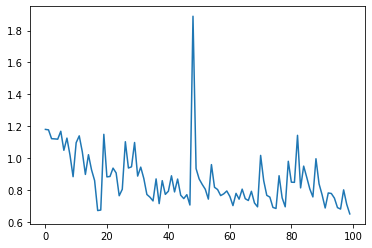

Epoch 1/100
11/11 - 9s - loss: 1.1726 - accuracy: 0.4620 - auc_22: 0.7008 - precision_22: 0.0000e+00 - recall_22: 0.0000e+00 - f1_score: 0.3052 - val_loss: 1.0742 - val_accuracy: 0.4865 - val_auc_22: 0.7692 - val_precision_22: 0.0000e+00 - val_recall_22: 0.0000e+00 - val_f1_score: 0.2182 - 9s/epoch - 796ms/step
Epoch 2/100
11/11 - 1s - loss: 1.1359 - accuracy: 0.5805 - auc_22: 0.7718 - precision_22: 0.0000e+00 - recall_22: 0.0000e+00 - f1_score: 0.4048 - val_loss: 1.0907 - val_accuracy: 0.4595 - val_auc_22: 0.5069 - val_precision_22: 0.0000e+00 - val_recall_22: 0.0000e+00 - val_f1_score: 0.2267 - 1s/epoch - 119ms/step
Epoch 3/100
11/11 - 1s - loss: 1.1049 - accuracy: 0.5684 - auc_22: 0.7803 - precision_22: 0.6667 - recall_22: 0.0061 - f1_score: 0.3514 - val_loss: 1.0926 - val_accuracy: 0.2432 - val_auc_22: 0.4626 - val_precision_22: 0.0000e+00 - val_recall_22: 0.0000e+00 - val_f1_score: 0.2276 - 1s/epoch - 118ms/step
Epoch 4/100
11/11 - 1s - loss: 1.0031 - accuracy: 0.5410 - auc_22: 0.

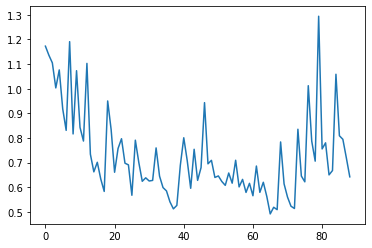

Epoch 1/100
11/11 - 8s - loss: 1.1780 - accuracy: 0.4377 - auc_23: 0.6790 - precision_23: 0.0000e+00 - recall_23: 0.0000e+00 - f1_score: 0.2569 - val_loss: 1.0570 - val_accuracy: 0.4595 - val_auc_23: 0.7387 - val_precision_23: 0.0000e+00 - val_recall_23: 0.0000e+00 - val_f1_score: 0.2714 - 8s/epoch - 735ms/step
Epoch 2/100
11/11 - 1s - loss: 1.1074 - accuracy: 0.5350 - auc_23: 0.7670 - precision_23: 0.3333 - recall_23: 0.0030 - f1_score: 0.4090 - val_loss: 1.0681 - val_accuracy: 0.5405 - val_auc_23: 0.7493 - val_precision_23: 0.0000e+00 - val_recall_23: 0.0000e+00 - val_f1_score: 0.3092 - 1s/epoch - 118ms/step
Epoch 3/100
11/11 - 1s - loss: 1.1215 - accuracy: 0.5562 - auc_23: 0.7672 - precision_23: 0.7273 - recall_23: 0.0243 - f1_score: 0.3903 - val_loss: 1.0799 - val_accuracy: 0.2973 - val_auc_23: 0.5497 - val_precision_23: 0.0000e+00 - val_recall_23: 0.0000e+00 - val_f1_score: 0.2667 - 1s/epoch - 121ms/step
Epoch 4/100
11/11 - 1s - loss: 1.0058 - accuracy: 0.4833 - auc_23: 0.7190 - p

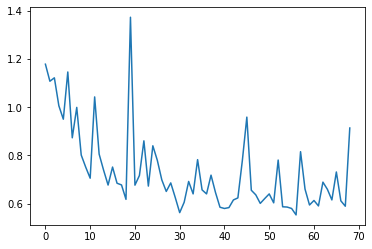

Epoch 1/100
11/11 - 8s - loss: 1.0288 - accuracy: 0.5684 - auc_24: 0.7760 - precision_24: 0.6000 - recall_24: 0.0091 - f1_score: 0.2693 - val_loss: 1.0519 - val_accuracy: 0.5405 - val_auc_24: 0.7474 - val_precision_24: 0.0000e+00 - val_recall_24: 0.0000e+00 - val_f1_score: 0.3410 - 8s/epoch - 732ms/step
Epoch 2/100
11/11 - 1s - loss: 0.9730 - accuracy: 0.5653 - auc_24: 0.7841 - precision_24: 0.7333 - recall_24: 0.0334 - f1_score: 0.3444 - val_loss: 1.0612 - val_accuracy: 0.4595 - val_auc_24: 0.7312 - val_precision_24: 0.0000e+00 - val_recall_24: 0.0000e+00 - val_f1_score: 0.2968 - 1s/epoch - 119ms/step
Epoch 3/100
11/11 - 1s - loss: 0.8878 - accuracy: 0.5410 - auc_24: 0.7860 - precision_24: 0.6562 - recall_24: 0.1277 - f1_score: 0.3019 - val_loss: 1.0604 - val_accuracy: 0.4595 - val_auc_24: 0.7135 - val_precision_24: 0.0000e+00 - val_recall_24: 0.0000e+00 - val_f1_score: 0.2744 - 1s/epoch - 118ms/step
Epoch 4/100
11/11 - 1s - loss: 0.7933 - accuracy: 0.5653 - auc_24: 0.7808 - precision

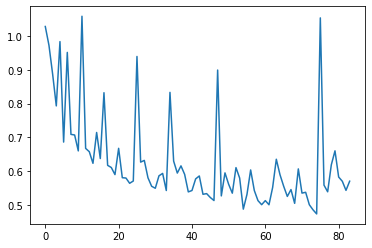

Epoch 1/100
11/11 - 8s - loss: 1.1446 - accuracy: 0.3191 - auc_25: 0.5448 - precision_25: 0.0000e+00 - recall_25: 0.0000e+00 - f1_score: 0.2306 - val_loss: 1.0688 - val_accuracy: 0.4595 - val_auc_25: 0.7379 - val_precision_25: 0.0000e+00 - val_recall_25: 0.0000e+00 - val_f1_score: 0.2714 - 8s/epoch - 737ms/step
Epoch 2/100
11/11 - 1s - loss: 1.1622 - accuracy: 0.5410 - auc_25: 0.7688 - precision_25: 0.0000e+00 - recall_25: 0.0000e+00 - f1_score: 0.3216 - val_loss: 1.0881 - val_accuracy: 0.4595 - val_auc_25: 0.7201 - val_precision_25: 0.0000e+00 - val_recall_25: 0.0000e+00 - val_f1_score: 0.2714 - 1s/epoch - 118ms/step
Epoch 3/100
11/11 - 1s - loss: 1.1046 - accuracy: 0.5198 - auc_25: 0.7495 - precision_25: 0.0000e+00 - recall_25: 0.0000e+00 - f1_score: 0.3814 - val_loss: 1.0864 - val_accuracy: 0.5135 - val_auc_25: 0.5822 - val_precision_25: 0.0000e+00 - val_recall_25: 0.0000e+00 - val_f1_score: 0.3834 - 1s/epoch - 117ms/step
Epoch 4/100
11/11 - 1s - loss: 1.0631 - accuracy: 0.5076 - au

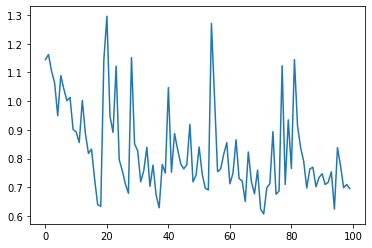

Epoch 1/100
11/11 - 8s - loss: 1.1772 - accuracy: 0.4758 - auc_26: 0.7365 - precision_26: 0.0000e+00 - recall_26: 0.0000e+00 - f1_score: 0.3172 - val_loss: 1.1090 - val_accuracy: 0.3889 - val_auc_26: 0.4074 - val_precision_26: 0.0000e+00 - val_recall_26: 0.0000e+00 - val_f1_score: 0.1867 - 8s/epoch - 762ms/step
Epoch 2/100
11/11 - 1s - loss: 1.0807 - accuracy: 0.4697 - auc_26: 0.7348 - precision_26: 0.0000e+00 - recall_26: 0.0000e+00 - f1_score: 0.4019 - val_loss: 1.1221 - val_accuracy: 0.2500 - val_auc_26: 0.3466 - val_precision_26: 0.0000e+00 - val_recall_26: 0.0000e+00 - val_f1_score: 0.1463 - 1s/epoch - 117ms/step
Epoch 3/100
11/11 - 1s - loss: 1.2070 - accuracy: 0.4727 - auc_26: 0.7382 - precision_26: 0.8000 - recall_26: 0.0121 - f1_score: 0.3448 - val_loss: 1.1349 - val_accuracy: 0.0833 - val_auc_26: 0.2687 - val_precision_26: 0.0000e+00 - val_recall_26: 0.0000e+00 - val_f1_score: 0.0833 - 1s/epoch - 116ms/step
Epoch 4/100
11/11 - 1s - loss: 1.0933 - accuracy: 0.4364 - auc_26: 0.

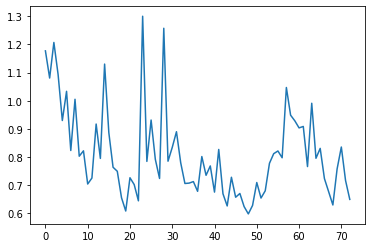

Epoch 1/100
11/11 - 8s - loss: 1.1603 - accuracy: 0.4727 - auc_27: 0.6395 - precision_27: 0.0000e+00 - recall_27: 0.0000e+00 - f1_score: 0.3300 - val_loss: 1.0694 - val_accuracy: 0.6389 - val_auc_27: 0.8164 - val_precision_27: 0.0000e+00 - val_recall_27: 0.0000e+00 - val_f1_score: 0.2599 - 8s/epoch - 743ms/step
Epoch 2/100
11/11 - 1s - loss: 1.2087 - accuracy: 0.5545 - auc_27: 0.7667 - precision_27: 0.5000 - recall_27: 0.0061 - f1_score: 0.3501 - val_loss: 1.0692 - val_accuracy: 0.5556 - val_auc_27: 0.7641 - val_precision_27: 0.0000e+00 - val_recall_27: 0.0000e+00 - val_f1_score: 0.3667 - 1s/epoch - 119ms/step
Epoch 3/100
11/11 - 1s - loss: 1.0647 - accuracy: 0.4970 - auc_27: 0.7494 - precision_27: 0.0000e+00 - recall_27: 0.0000e+00 - f1_score: 0.4442 - val_loss: 1.0579 - val_accuracy: 0.6111 - val_auc_27: 0.7870 - val_precision_27: 0.0000e+00 - val_recall_27: 0.0000e+00 - val_f1_score: 0.2917 - 1s/epoch - 117ms/step
Epoch 4/100
11/11 - 1s - loss: 1.1537 - accuracy: 0.4970 - auc_27: 0.

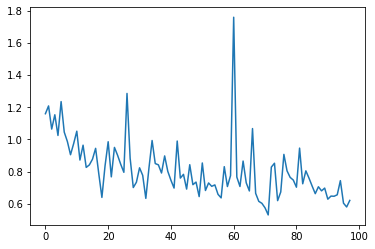

Epoch 1/100
11/11 - 8s - loss: 0.9935 - accuracy: 0.5455 - auc_28: 0.7414 - precision_28: 0.0000e+00 - recall_28: 0.0000e+00 - f1_score: 0.2598 - val_loss: 1.0632 - val_accuracy: 0.5833 - val_auc_28: 0.7257 - val_precision_28: 0.0000e+00 - val_recall_28: 0.0000e+00 - val_f1_score: 0.2456 - 8s/epoch - 689ms/step
Epoch 2/100
11/11 - 1s - loss: 0.9954 - accuracy: 0.5636 - auc_28: 0.7808 - precision_28: 0.6000 - recall_28: 0.0182 - f1_score: 0.3511 - val_loss: 1.0583 - val_accuracy: 0.6111 - val_auc_28: 0.6979 - val_precision_28: 0.0000e+00 - val_recall_28: 0.0000e+00 - val_f1_score: 0.3909 - 1s/epoch - 109ms/step
Epoch 3/100
11/11 - 1s - loss: 1.0239 - accuracy: 0.5576 - auc_28: 0.7747 - precision_28: 0.8182 - recall_28: 0.0273 - f1_score: 0.3633 - val_loss: 1.0614 - val_accuracy: 0.6111 - val_auc_28: 0.7840 - val_precision_28: 0.0000e+00 - val_recall_28: 0.0000e+00 - val_f1_score: 0.3489 - 1s/epoch - 106ms/step
Epoch 4/100
11/11 - 1s - loss: 0.9767 - accuracy: 0.5758 - auc_28: 0.7870 - p

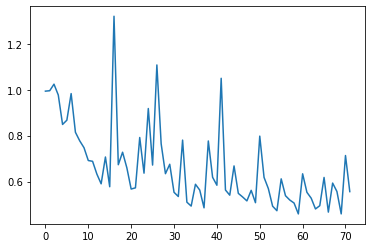

Epoch 1/100
11/11 - 8s - loss: 1.1468 - accuracy: 0.3394 - auc_29: 0.4924 - precision_29: 0.0000e+00 - recall_29: 0.0000e+00 - f1_score: 0.2456 - val_loss: 1.0895 - val_accuracy: 0.3889 - val_auc_29: 0.7081 - val_precision_29: 0.0000e+00 - val_recall_29: 0.0000e+00 - val_f1_score: 0.2083 - 8s/epoch - 690ms/step
Epoch 2/100
11/11 - 1s - loss: 1.1652 - accuracy: 0.4091 - auc_29: 0.6923 - precision_29: 0.0000e+00 - recall_29: 0.0000e+00 - f1_score: 0.2265 - val_loss: 1.0852 - val_accuracy: 0.4167 - val_auc_29: 0.6792 - val_precision_29: 0.0000e+00 - val_recall_29: 0.0000e+00 - val_f1_score: 0.2377 - 1s/epoch - 108ms/step
Epoch 3/100
11/11 - 1s - loss: 1.1622 - accuracy: 0.4727 - auc_29: 0.7217 - precision_29: 0.0000e+00 - recall_29: 0.0000e+00 - f1_score: 0.2938 - val_loss: 1.0805 - val_accuracy: 0.3889 - val_auc_29: 0.6827 - val_precision_29: 0.0000e+00 - val_recall_29: 0.0000e+00 - val_f1_score: 0.2381 - 1s/epoch - 109ms/step
Epoch 4/100
11/11 - 1s - loss: 1.2790 - accuracy: 0.4909 - au

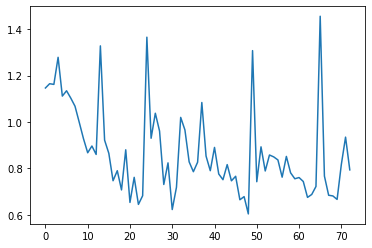

In [28]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []
val_accuracy = 0.0
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    cnnlstm_intensity_face_model = CNNLSTM(n_features, n_length, n_outputs, multiclass=True)
    history = cnnlstm_intensity_face_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=32, class_weight=d_class_weights)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        cnnlstm_intensity_face_model.save(model_path / 'face_intensity_cnnlstm.h5')

#### Training performance and variance

In [29]:
face_cnnlstm_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
face_cnnlstm_train_results

{'Accuracy': 0.5637643963098526,
 'ROC/AUC': 0.7823121070861816,
 'Precision': 0.588945934176445,
 'Recall': 0.5273427307605744,
 'F1-score': 0.43424632847309114}

In [30]:
face_cnnlstm_train_var = {'Accuracy': np.var(acc), 'ROC/AUC': np.var(auc), 'Precision': np.var(precision), 'Recall': np.var(recall), 'F1-score': np.var(f1)}
face_cnnlstm_train_var

{'Accuracy': 0.004970103827095054,
 'ROC/AUC': 0.0033571520877436005,
 'Precision': 0.005204573944513778,
 'Recall': 0.007632198151638967,
 'F1-score': 0.00224653401573204}

#### Validation performance and variance

In [31]:
face_cnnlstm_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
face_cnnlstm_val_results

{'Accuracy': 0.5076576560735703,
 'ROC/AUC': 0.7551171720027924,
 'Precision': 0.5200037658214569,
 'Recall': 0.4856606602668762,
 'F1-score': 0.3308515876531601}

In [32]:
face_cnnlstm_val_var = {'Accuracy': np.var(acc_val), 'ROC/AUC': np.var(auc_val), 'Precision': np.var(precision_val), 'Recall': np.var(recall_val), 'F1-score': np.var(f1_val)}
face_cnnlstm_val_var

{'Accuracy': 0.007575683624711091,
 'ROC/AUC': 0.0029723028356822925,
 'Precision': 0.00808762670316554,
 'Recall': 0.009479124611520574,
 'F1-score': 0.003212967966462168}

#### Predictions and performance on test set

In [34]:
cnnlstm_intensity_face_model = load_model(model_path / 'face_intensity_cnnlstm.h5')
y_pred = cnnlstm_intensity_face_model.predict(X_test)
_, acc, auc, precision, recall, f1 = cnnlstm_intensity_face_model.evaluate(X_test, y_test)
cnnlstm_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

8/8 [==============================] - 2s 35ms/step - loss: 0.7946 - accuracy: 0.6190 - auc_25: 0.8169 - precision_25: 0.6199 - recall_25: 0.5931 - f1_score: 0.3365
Accuracy: 61.90% 
ROC/AUC: 0.82 
Precision: 0.62 
Recall: 0.59 
F1 score: 0.34


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

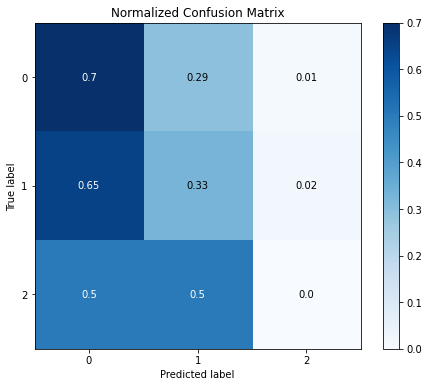

In [35]:
skplt.metrics.plot_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize=True, figsize=(8,6))

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

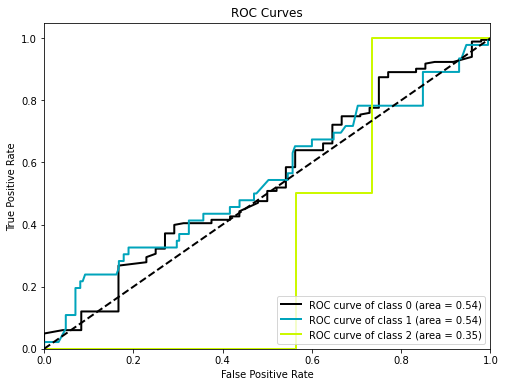

In [36]:
skplt.metrics.plot_roc(y_test.argmax(axis=1), y_pred, plot_micro=False, plot_macro=False, figsize=(8,6))

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

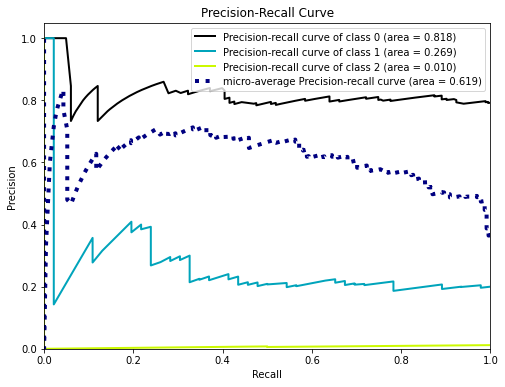

In [37]:
skplt.metrics.plot_precision_recall_curve(y_test.argmax(axis=1), y_pred, figsize=(8,6))

### 2.2 RCNN

Epoch 1/100
11/11 - 3s - loss: 1.7989 - accuracy: 0.4012 - auc_30: 0.5908 - precision_30: 0.3868 - recall_30: 0.1246 - f1_score: 0.2829 - val_loss: 1.0817 - val_accuracy: 0.4595 - val_auc_30: 0.4872 - val_precision_30: 1.0000 - val_recall_30: 0.0270 - val_f1_score: 0.2099 - 3s/epoch - 265ms/step
Epoch 2/100
11/11 - 0s - loss: 1.1942 - accuracy: 0.4833 - auc_30: 0.6501 - precision_30: 0.4766 - recall_30: 0.1550 - f1_score: 0.2806 - val_loss: 3.2213 - val_accuracy: 0.5135 - val_auc_30: 0.7169 - val_precision_30: 0.0000e+00 - val_recall_30: 0.0000e+00 - val_f1_score: 0.2262 - 305ms/epoch - 28ms/step
Epoch 3/100
11/11 - 0s - loss: 2.7325 - accuracy: 0.5015 - auc_30: 0.5958 - precision_30: 0.4208 - recall_30: 0.2340 - f1_score: 0.2951 - val_loss: 1.0701 - val_accuracy: 0.5135 - val_auc_30: 0.7235 - val_precision_30: 0.0000e+00 - val_recall_30: 0.0000e+00 - val_f1_score: 0.2262 - 307ms/epoch - 28ms/step
Epoch 4/100
11/11 - 0s - loss: 1.4402 - accuracy: 0.4103 - auc_30: 0.5317 - precision_30:

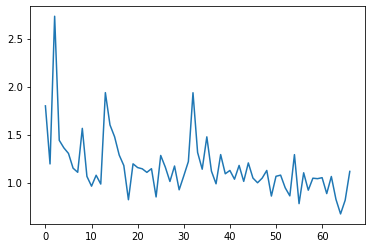

Epoch 1/100
11/11 - 3s - loss: 1.4700 - accuracy: 0.4316 - auc_31: 0.6235 - precision_31: 0.4355 - recall_31: 0.1641 - f1_score: 0.3005 - val_loss: 1.4494 - val_accuracy: 0.3784 - val_auc_31: 0.6654 - val_precision_31: 0.5000 - val_recall_31: 0.0270 - val_f1_score: 0.2035 - 3s/epoch - 236ms/step
Epoch 2/100
11/11 - 0s - loss: 1.1813 - accuracy: 0.3921 - auc_31: 0.5872 - precision_31: 0.2970 - recall_31: 0.1489 - f1_score: 0.2905 - val_loss: 1.2581 - val_accuracy: 0.6216 - val_auc_31: 0.7946 - val_precision_31: 0.5000 - val_recall_31: 0.0270 - val_f1_score: 0.2556 - 306ms/epoch - 28ms/step
Epoch 3/100
11/11 - 0s - loss: 1.4349 - accuracy: 0.3222 - auc_31: 0.5965 - precision_31: 0.4074 - recall_31: 0.2340 - f1_score: 0.2798 - val_loss: 2.1938 - val_accuracy: 0.6216 - val_auc_31: 0.6364 - val_precision_31: 0.5000 - val_recall_31: 0.0270 - val_f1_score: 0.2556 - 297ms/epoch - 27ms/step
Epoch 4/100
11/11 - 0s - loss: 1.3944 - accuracy: 0.5046 - auc_31: 0.6824 - precision_31: 0.5273 - recall

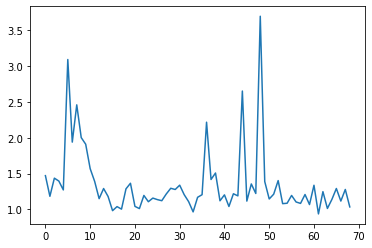

Epoch 1/100
11/11 - 3s - loss: 1.6987 - accuracy: 0.4255 - auc_32: 0.6434 - precision_32: 0.4068 - recall_32: 0.0729 - f1_score: 0.3135 - val_loss: 1.6574 - val_accuracy: 0.4865 - val_auc_32: 0.4996 - val_precision_32: 0.0000e+00 - val_recall_32: 0.0000e+00 - val_f1_score: 0.2264 - 3s/epoch - 234ms/step
Epoch 2/100
11/11 - 0s - loss: 1.3545 - accuracy: 0.4043 - auc_32: 0.5785 - precision_32: 0.4000 - recall_32: 0.1702 - f1_score: 0.2565 - val_loss: 1.0343 - val_accuracy: 0.5135 - val_auc_32: 0.6549 - val_precision_32: 1.0000 - val_recall_32: 0.0541 - val_f1_score: 0.2262 - 310ms/epoch - 28ms/step
Epoch 3/100
11/11 - 0s - loss: 1.4252 - accuracy: 0.3647 - auc_32: 0.5522 - precision_32: 0.3736 - recall_32: 0.1033 - f1_score: 0.2707 - val_loss: 0.9668 - val_accuracy: 0.5405 - val_auc_32: 0.7827 - val_precision_32: 1.0000 - val_recall_32: 0.0541 - val_f1_score: 0.2899 - 306ms/epoch - 28ms/step
Epoch 4/100
11/11 - 0s - loss: 1.8105 - accuracy: 0.3708 - auc_32: 0.5866 - precision_32: 0.3869 

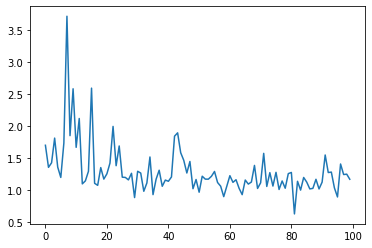

Epoch 1/100
11/11 - 3s - loss: 1.6550 - accuracy: 0.3404 - auc_33: 0.5873 - precision_33: 0.3593 - recall_33: 0.1824 - f1_score: 0.2689 - val_loss: 1.1266 - val_accuracy: 0.5676 - val_auc_33: 0.5778 - val_precision_33: 0.5000 - val_recall_33: 0.0270 - val_f1_score: 0.2414 - 3s/epoch - 237ms/step
Epoch 2/100
11/11 - 0s - loss: 1.8959 - accuracy: 0.2401 - auc_33: 0.4519 - precision_33: 0.2500 - recall_33: 0.1033 - f1_score: 0.2091 - val_loss: 1.1340 - val_accuracy: 0.4324 - val_auc_33: 0.4500 - val_precision_33: 0.5000 - val_recall_33: 0.0270 - val_f1_score: 0.2251 - 292ms/epoch - 27ms/step
Epoch 3/100
11/11 - 0s - loss: 1.3739 - accuracy: 0.3161 - auc_33: 0.5332 - precision_33: 0.4091 - recall_33: 0.0547 - f1_score: 0.2346 - val_loss: 1.4106 - val_accuracy: 0.0270 - val_auc_33: 0.3214 - val_precision_33: 0.5000 - val_recall_33: 0.0270 - val_f1_score: 0.0290 - 295ms/epoch - 27ms/step
Epoch 4/100
11/11 - 0s - loss: 1.1997 - accuracy: 0.2979 - auc_33: 0.5146 - precision_33: 0.3627 - recall

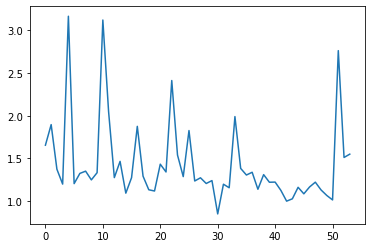

Epoch 1/100
11/11 - 3s - loss: 1.3511 - accuracy: 0.4347 - auc_34: 0.6424 - precision_34: 0.4444 - recall_34: 0.1945 - f1_score: 0.3016 - val_loss: 2.6354 - val_accuracy: 0.5946 - val_auc_34: 0.7023 - val_precision_34: 0.5000 - val_recall_34: 0.0270 - val_f1_score: 0.3989 - 3s/epoch - 266ms/step
Epoch 2/100
11/11 - 0s - loss: 3.0366 - accuracy: 0.4438 - auc_34: 0.6948 - precision_34: 0.4912 - recall_34: 0.2553 - f1_score: 0.3118 - val_loss: 1.1305 - val_accuracy: 0.4324 - val_auc_34: 0.4702 - val_precision_34: 0.5000 - val_recall_34: 0.0270 - val_f1_score: 0.2051 - 309ms/epoch - 28ms/step
Epoch 3/100
11/11 - 0s - loss: 1.1305 - accuracy: 0.4164 - auc_34: 0.6325 - precision_34: 0.4545 - recall_34: 0.2128 - f1_score: 0.3067 - val_loss: 1.2117 - val_accuracy: 0.0270 - val_auc_34: 0.2568 - val_precision_34: 0.0000e+00 - val_recall_34: 0.0000e+00 - val_f1_score: 0.0180 - 299ms/epoch - 27ms/step
Epoch 4/100
11/11 - 0s - loss: 0.8198 - accuracy: 0.4894 - auc_34: 0.7328 - precision_34: 0.5591 

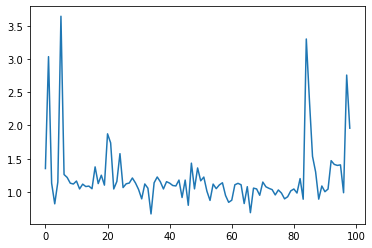

Epoch 1/100
11/11 - 3s - loss: 2.8355 - accuracy: 0.3799 - auc_35: 0.5790 - precision_35: 0.3101 - recall_35: 0.1489 - f1_score: 0.2827 - val_loss: 1.1184 - val_accuracy: 0.5946 - val_auc_35: 0.7747 - val_precision_35: 0.5000 - val_recall_35: 0.0270 - val_f1_score: 0.2486 - 3s/epoch - 238ms/step
Epoch 2/100
11/11 - 0s - loss: 1.5416 - accuracy: 0.3131 - auc_35: 0.5186 - precision_35: 0.2627 - recall_35: 0.0942 - f1_score: 0.2511 - val_loss: 0.9985 - val_accuracy: 0.4324 - val_auc_35: 0.7316 - val_precision_35: 1.0000 - val_recall_35: 0.0541 - val_f1_score: 0.2438 - 305ms/epoch - 28ms/step
Epoch 3/100
11/11 - 0s - loss: 1.2204 - accuracy: 0.4894 - auc_35: 0.7018 - precision_35: 0.4308 - recall_35: 0.0851 - f1_score: 0.3283 - val_loss: 0.9594 - val_accuracy: 0.6216 - val_auc_35: 0.8249 - val_precision_35: 1.0000 - val_recall_35: 0.0541 - val_f1_score: 0.2556 - 308ms/epoch - 28ms/step
Epoch 4/100
11/11 - 0s - loss: 1.2447 - accuracy: 0.4681 - auc_35: 0.6966 - precision_35: 0.4818 - recall

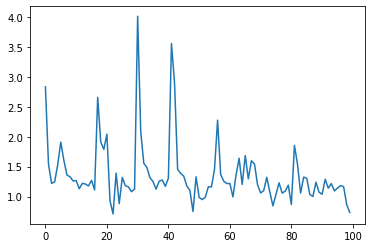

Epoch 1/100
11/11 - 3s - loss: 3.1818 - accuracy: 0.4182 - auc_36: 0.6119 - precision_36: 0.5049 - recall_36: 0.1576 - f1_score: 0.3050 - val_loss: 1.0679 - val_accuracy: 0.4167 - val_auc_36: 0.4676 - val_precision_36: 1.0000 - val_recall_36: 0.0278 - val_f1_score: 0.1961 - 3s/epoch - 238ms/step
Epoch 2/100
11/11 - 0s - loss: 1.4441 - accuracy: 0.2727 - auc_36: 0.4717 - precision_36: 0.2289 - recall_36: 0.0576 - f1_score: 0.2325 - val_loss: 3.5171 - val_accuracy: 0.3333 - val_auc_36: 0.4786 - val_precision_36: 0.0000e+00 - val_recall_36: 0.0000e+00 - val_f1_score: 0.1905 - 297ms/epoch - 27ms/step
Epoch 3/100
11/11 - 0s - loss: 1.5334 - accuracy: 0.4152 - auc_36: 0.5823 - precision_36: 0.4631 - recall_36: 0.2091 - f1_score: 0.3024 - val_loss: 2.7251 - val_accuracy: 0.5833 - val_auc_36: 0.5673 - val_precision_36: 0.0000e+00 - val_recall_36: 0.0000e+00 - val_f1_score: 0.2456 - 293ms/epoch - 27ms/step
Epoch 4/100
11/11 - 0s - loss: 1.3992 - accuracy: 0.2667 - auc_36: 0.4810 - precision_36:

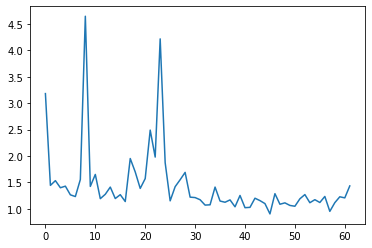

Epoch 1/100
11/11 - 3s - loss: 2.2407 - accuracy: 0.2848 - auc_37: 0.4597 - precision_37: 0.3101 - recall_37: 0.1485 - f1_score: 0.2321 - val_loss: 2.3223 - val_accuracy: 0.3889 - val_auc_37: 0.4161 - val_precision_37: 0.3333 - val_recall_37: 0.0278 - val_f1_score: 0.2162 - 3s/epoch - 238ms/step
Epoch 2/100
11/11 - 0s - loss: 1.9820 - accuracy: 0.3182 - auc_37: 0.5141 - precision_37: 0.2577 - recall_37: 0.0758 - f1_score: 0.2613 - val_loss: 2.3382 - val_accuracy: 0.3611 - val_auc_37: 0.3711 - val_precision_37: 0.0000e+00 - val_recall_37: 0.0000e+00 - val_f1_score: 0.1844 - 296ms/epoch - 27ms/step
Epoch 3/100
11/11 - 0s - loss: 1.4619 - accuracy: 0.4576 - auc_37: 0.6720 - precision_37: 0.4356 - recall_37: 0.1333 - f1_score: 0.3034 - val_loss: 2.0054 - val_accuracy: 0.3889 - val_auc_37: 0.4028 - val_precision_37: 0.3333 - val_recall_37: 0.0278 - val_f1_score: 0.2083 - 302ms/epoch - 27ms/step
Epoch 4/100
11/11 - 0s - loss: 1.2125 - accuracy: 0.4333 - auc_37: 0.6587 - precision_37: 0.4297 

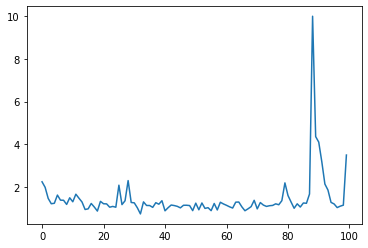

Epoch 1/100
11/11 - 3s - loss: 1.3336 - accuracy: 0.4636 - auc_38: 0.6032 - precision_38: 0.4839 - recall_38: 0.0909 - f1_score: 0.3239 - val_loss: 3.4874 - val_accuracy: 0.3889 - val_auc_38: 0.6512 - val_precision_38: 0.0000e+00 - val_recall_38: 0.0000e+00 - val_f1_score: 0.1867 - 3s/epoch - 268ms/step
Epoch 2/100
11/11 - 0s - loss: 1.1474 - accuracy: 0.4909 - auc_38: 0.7123 - precision_38: 0.4865 - recall_38: 0.3818 - f1_score: 0.3261 - val_loss: 2.4219 - val_accuracy: 0.3889 - val_auc_38: 0.4043 - val_precision_38: 0.0000e+00 - val_recall_38: 0.0000e+00 - val_f1_score: 0.1867 - 304ms/epoch - 28ms/step
Epoch 3/100
11/11 - 0s - loss: 1.3095 - accuracy: 0.4182 - auc_38: 0.5577 - precision_38: 0.3801 - recall_38: 0.1970 - f1_score: 0.3026 - val_loss: 0.9877 - val_accuracy: 0.5833 - val_auc_38: 0.7992 - val_precision_38: 1.0000 - val_recall_38: 0.0278 - val_f1_score: 0.2456 - 309ms/epoch - 28ms/step
Epoch 4/100
11/11 - 0s - loss: 1.0694 - accuracy: 0.5667 - auc_38: 0.7498 - precision_38:

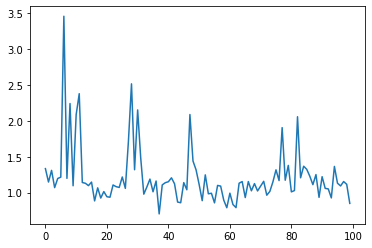

Epoch 1/100
11/11 - 3s - loss: 1.9010 - accuracy: 0.5485 - auc_39: 0.7586 - precision_39: 0.5773 - recall_39: 0.3394 - f1_score: 0.3344 - val_loss: 1.0645 - val_accuracy: 0.6389 - val_auc_39: 0.5399 - val_precision_39: 1.0000 - val_recall_39: 0.0278 - val_f1_score: 0.2599 - 3s/epoch - 236ms/step
Epoch 2/100
11/11 - 0s - loss: 1.2048 - accuracy: 0.1152 - auc_39: 0.3869 - precision_39: 0.2138 - recall_39: 0.0939 - f1_score: 0.1302 - val_loss: 1.1021 - val_accuracy: 0.0278 - val_auc_39: 0.2776 - val_precision_39: 1.0000 - val_recall_39: 0.0278 - val_f1_score: 0.0278 - 316ms/epoch - 29ms/step
Epoch 3/100
11/11 - 0s - loss: 1.1901 - accuracy: 0.2152 - auc_39: 0.4047 - precision_39: 0.2891 - recall_39: 0.1121 - f1_score: 0.2065 - val_loss: 1.0518 - val_accuracy: 0.3611 - val_auc_39: 0.6620 - val_precision_39: 0.0000e+00 - val_recall_39: 0.0000e+00 - val_f1_score: 0.1769 - 309ms/epoch - 28ms/step
Epoch 4/100
11/11 - 0s - loss: 3.3562 - accuracy: 0.3485 - auc_39: 0.5170 - precision_39: 0.2989 

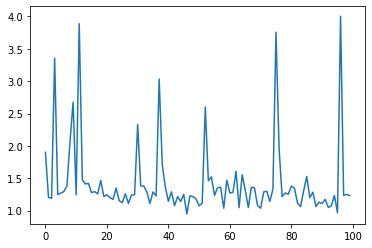

In [38]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []
val_accuracy = 0.0
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    rcnn_intensity_face_model = RCNN(n_features, n_length, n_outputs, multiclass=True)
    history = rcnn_intensity_face_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=32, class_weight=d_class_weights)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        rcnn_intensity_face_model.save(model_path / 'face_intensity_rcnn.h5')

#### Training performance and variance

In [39]:
face_rcnn_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
face_rcnn_train_results

{'Accuracy': 0.3767808794975281,
 'ROC/AUC': 0.6135593891143799,
 'Precision': 0.47077091187238695,
 'Recall': 0.18847195506095887,
 'F1-score': 0.31218634992837907}

In [40]:
face_rcnn_train_var = {'Accuracy': np.var(acc), 'ROC/AUC': np.var(auc), 'Precision': np.var(precision), 'Recall': np.var(recall), 'F1-score': np.var(f1)}
face_rcnn_train_var

{'Accuracy': 0.019625059931551895,
 'ROC/AUC': 0.01513484760825122,
 'Precision': 0.028799395530209826,
 'Recall': 0.005771546931577145,
 'F1-score': 0.015066740934107337}

#### Validation performance and variance

In [41]:
face_rcnn_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
face_rcnn_val_results

{'Accuracy': 0.3561561554670334,
 'ROC/AUC': 0.558116826415062,
 'Precision': 0.4102102130651474,
 'Recall': 0.22102102413773536,
 'F1-score': 0.175662362575531}

In [42]:
face_rcnn_val_var = {'Accuracy': np.var(acc_val), 'ROC/AUC': np.var(auc_val), 'Precision': np.var(precision_val), 'Recall': np.var(recall_val), 'F1-score': np.var(f1_val)}
face_rcnn_val_var

{'Accuracy': 0.03553995269410835,
 'ROC/AUC': 0.04175233342260762,
 'Precision': 0.07136091020160402,
 'Recall': 0.04122131212884119,
 'F1-score': 0.008517318477573406}

#### Predictions and performance on test set

In [43]:
rcnn_intensity_face_model = load_model(model_path / 'face_intensity_rcnn.h5')
y_pred = rcnn_intensity_face_model.predict(X_test)
_, acc, auc, precision, recall, f1 = rcnn_intensity_face_model.evaluate(X_test, y_test)
rcnn_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

8/8 [==============================] - 1s 10ms/step - loss: 0.7417 - accuracy: 0.7922 - auc_34: 0.8936 - precision_34: 1.0000 - recall_34: 0.0260 - f1_score: 0.2947
Accuracy: 79.22% 
ROC/AUC: 0.89 
Precision: 1.00 
Recall: 0.03 
F1 score: 0.29


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

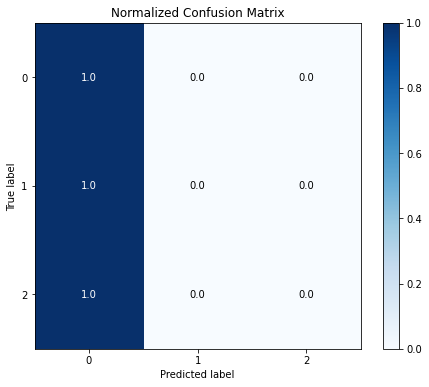

In [44]:
skplt.metrics.plot_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize=True, figsize=(8,6))

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

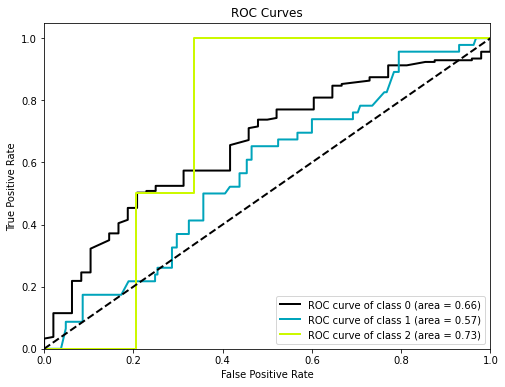

In [45]:
skplt.metrics.plot_roc(y_test.argmax(axis=1), y_pred, plot_micro=False, plot_macro=False, figsize=(8,6))

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

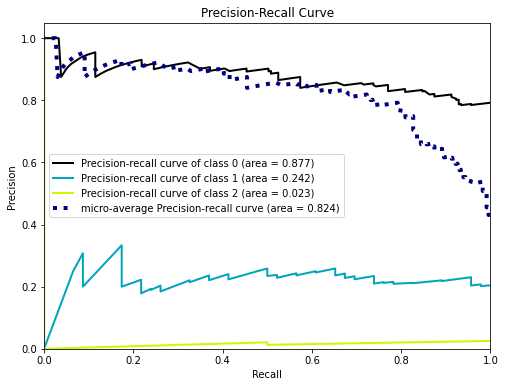

In [46]:
skplt.metrics.plot_precision_recall_curve(y_test.argmax(axis=1), y_pred, figsize=(8,6))

## 3. Multimodal Early Fusion

In [47]:
X_train, X_test, y_train, y_test = load_fusioned_dataset(level=True, nopain=False)
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

(366, 1, 350, 60) (366, 3)
(231, 1, 350, 60) (231, 3)


### 3.1 CNN + BiLSTM

Epoch 1/100
11/11 - 9s - loss: 0.9745 - accuracy: 0.4225 - auc_40: 0.6489 - precision_40: 0.0000e+00 - recall_40: 0.0000e+00 - f1_score: 0.3073 - val_loss: 1.0066 - val_accuracy: 0.4595 - val_auc_40: 0.7138 - val_precision_40: 0.0000e+00 - val_recall_40: 0.0000e+00 - val_f1_score: 0.2099 - 9s/epoch - 777ms/step
Epoch 2/100
11/11 - 1s - loss: 1.0246 - accuracy: 0.5684 - auc_40: 0.7838 - precision_40: 0.6429 - recall_40: 0.0274 - f1_score: 0.3668 - val_loss: 1.0181 - val_accuracy: 0.4595 - val_auc_40: 0.7330 - val_precision_40: 1.0000 - val_recall_40: 0.0270 - val_f1_score: 0.2099 - 1s/epoch - 119ms/step
Epoch 3/100
11/11 - 1s - loss: 1.0426 - accuracy: 0.5805 - auc_40: 0.7981 - precision_40: 0.7000 - recall_40: 0.0426 - f1_score: 0.3350 - val_loss: 1.0447 - val_accuracy: 0.4595 - val_auc_40: 0.7330 - val_precision_40: 1.0000 - val_recall_40: 0.0270 - val_f1_score: 0.2099 - 1s/epoch - 118ms/step
Epoch 4/100
11/11 - 1s - loss: 1.1130 - accuracy: 0.6049 - auc_40: 0.7983 - precision_40: 0.6

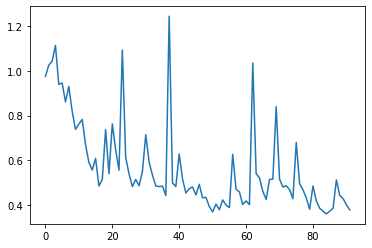

Epoch 1/100
11/11 - 8s - loss: 1.1505 - accuracy: 0.4407 - auc_41: 0.6716 - precision_41: 0.0000e+00 - recall_41: 0.0000e+00 - f1_score: 0.2875 - val_loss: 1.0758 - val_accuracy: 0.4324 - val_auc_41: 0.6969 - val_precision_41: 0.0000e+00 - val_recall_41: 0.0000e+00 - val_f1_score: 0.2585 - 8s/epoch - 755ms/step
Epoch 2/100
11/11 - 1s - loss: 1.1631 - accuracy: 0.4833 - auc_41: 0.7321 - precision_41: 1.0000 - recall_41: 0.0030 - f1_score: 0.2949 - val_loss: 1.0687 - val_accuracy: 0.3243 - val_auc_41: 0.7138 - val_precision_41: 0.0000e+00 - val_recall_41: 0.0000e+00 - val_f1_score: 0.2109 - 1s/epoch - 120ms/step
Epoch 3/100
11/11 - 1s - loss: 1.1786 - accuracy: 0.6018 - auc_41: 0.7849 - precision_41: 0.3333 - recall_41: 0.0030 - f1_score: 0.4049 - val_loss: 1.0815 - val_accuracy: 0.5946 - val_auc_41: 0.7529 - val_precision_41: 0.0000e+00 - val_recall_41: 0.0000e+00 - val_f1_score: 0.2486 - 1s/epoch - 118ms/step
Epoch 4/100
11/11 - 1s - loss: 1.0173 - accuracy: 0.5562 - auc_41: 0.7996 - p

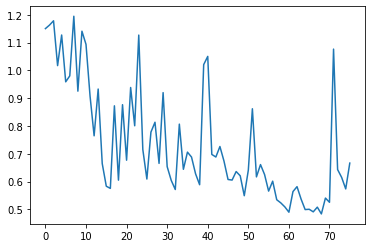

Epoch 1/100
11/11 - 8s - loss: 1.1633 - accuracy: 0.5471 - auc_42: 0.7718 - precision_42: 0.0000e+00 - recall_42: 0.0000e+00 - f1_score: 0.3328 - val_loss: 1.0477 - val_accuracy: 0.5135 - val_auc_42: 0.7555 - val_precision_42: 0.0000e+00 - val_recall_42: 0.0000e+00 - val_f1_score: 0.2262 - 8s/epoch - 772ms/step
Epoch 2/100
11/11 - 1s - loss: 1.2392 - accuracy: 0.5380 - auc_42: 0.7702 - precision_42: 1.0000 - recall_42: 0.0152 - f1_score: 0.3308 - val_loss: 1.0340 - val_accuracy: 0.5135 - val_auc_42: 0.7776 - val_precision_42: 0.0000e+00 - val_recall_42: 0.0000e+00 - val_f1_score: 0.2262 - 1s/epoch - 120ms/step
Epoch 3/100
11/11 - 1s - loss: 1.1518 - accuracy: 0.5836 - auc_42: 0.8049 - precision_42: 0.8333 - recall_42: 0.0304 - f1_score: 0.3777 - val_loss: 1.0537 - val_accuracy: 0.5405 - val_auc_42: 0.7907 - val_precision_42: 0.0000e+00 - val_recall_42: 0.0000e+00 - val_f1_score: 0.2654 - 1s/epoch - 118ms/step
Epoch 4/100
11/11 - 1s - loss: 1.1019 - accuracy: 0.5593 - auc_42: 0.7988 - p

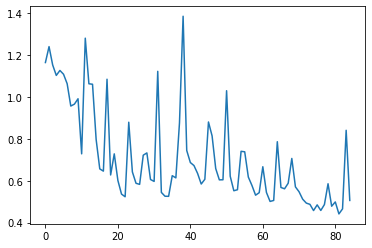

Epoch 1/100
11/11 - 8s - loss: 1.1916 - accuracy: 0.5289 - auc_43: 0.7634 - precision_43: 1.0000 - recall_43: 0.0030 - f1_score: 0.2772 - val_loss: 1.0054 - val_accuracy: 0.5676 - val_auc_43: 0.7982 - val_precision_43: 0.5000 - val_recall_43: 0.0270 - val_f1_score: 0.2414 - 8s/epoch - 728ms/step
Epoch 2/100
11/11 - 1s - loss: 1.1083 - accuracy: 0.5836 - auc_43: 0.7937 - precision_43: 0.7500 - recall_43: 0.0274 - f1_score: 0.3328 - val_loss: 1.0286 - val_accuracy: 0.5676 - val_auc_43: 0.7949 - val_precision_43: 0.0000e+00 - val_recall_43: 0.0000e+00 - val_f1_score: 0.2414 - 1s/epoch - 107ms/step
Epoch 3/100
11/11 - 1s - loss: 1.0814 - accuracy: 0.5775 - auc_43: 0.7850 - precision_43: 0.8571 - recall_43: 0.0182 - f1_score: 0.4439 - val_loss: 1.0543 - val_accuracy: 0.5676 - val_auc_43: 0.7694 - val_precision_43: 0.5000 - val_recall_43: 0.0270 - val_f1_score: 0.2414 - 1s/epoch - 107ms/step
Epoch 4/100
11/11 - 1s - loss: 1.1370 - accuracy: 0.5562 - auc_43: 0.7810 - precision_43: 0.8000 - re

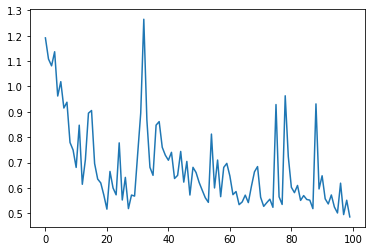

Epoch 1/100
11/11 - 8s - loss: 0.9878 - accuracy: 0.5410 - auc_44: 0.7647 - precision_44: 0.6667 - recall_44: 0.0061 - f1_score: 0.3068 - val_loss: 1.0298 - val_accuracy: 0.4595 - val_auc_44: 0.7427 - val_precision_44: 0.0000e+00 - val_recall_44: 0.0000e+00 - val_f1_score: 0.3039 - 8s/epoch - 710ms/step
Epoch 2/100
11/11 - 1s - loss: 1.0932 - accuracy: 0.5258 - auc_44: 0.7642 - precision_44: 0.5750 - recall_44: 0.0699 - f1_score: 0.3511 - val_loss: 1.0544 - val_accuracy: 0.4324 - val_auc_44: 0.7263 - val_precision_44: 0.0000e+00 - val_recall_44: 0.0000e+00 - val_f1_score: 0.2730 - 1s/epoch - 107ms/step
Epoch 3/100
11/11 - 1s - loss: 1.0225 - accuracy: 0.5258 - auc_44: 0.7756 - precision_44: 0.5769 - recall_44: 0.0912 - f1_score: 0.3511 - val_loss: 1.0685 - val_accuracy: 0.4865 - val_auc_44: 0.7390 - val_precision_44: 0.0000e+00 - val_recall_44: 0.0000e+00 - val_f1_score: 0.3011 - 1s/epoch - 107ms/step
Epoch 4/100
11/11 - 1s - loss: 0.8304 - accuracy: 0.5137 - auc_44: 0.7796 - precision

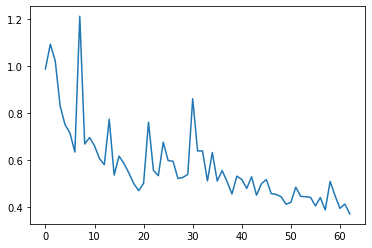

Epoch 1/100
11/11 - 8s - loss: 1.1434 - accuracy: 0.4620 - auc_45: 0.6263 - precision_45: 0.0000e+00 - recall_45: 0.0000e+00 - f1_score: 0.2803 - val_loss: 1.0370 - val_accuracy: 0.4324 - val_auc_45: 0.7091 - val_precision_45: 0.0000e+00 - val_recall_45: 0.0000e+00 - val_f1_score: 0.2438 - 8s/epoch - 737ms/step
Epoch 2/100
11/11 - 1s - loss: 1.1719 - accuracy: 0.5350 - auc_45: 0.7616 - precision_45: 1.0000 - recall_45: 0.0061 - f1_score: 0.3594 - val_loss: 1.0646 - val_accuracy: 0.4054 - val_auc_45: 0.7131 - val_precision_45: 0.0000e+00 - val_recall_45: 0.0000e+00 - val_f1_score: 0.2318 - 1s/epoch - 117ms/step
Epoch 3/100
11/11 - 1s - loss: 1.1738 - accuracy: 0.5805 - auc_45: 0.7791 - precision_45: 0.8750 - recall_45: 0.0213 - f1_score: 0.3871 - val_loss: 1.1025 - val_accuracy: 0.1892 - val_auc_45: 0.3585 - val_precision_45: 0.0000e+00 - val_recall_45: 0.0000e+00 - val_f1_score: 0.1852 - 1s/epoch - 118ms/step
Epoch 4/100
11/11 - 1s - loss: 1.0832 - accuracy: 0.4833 - auc_45: 0.7194 - p

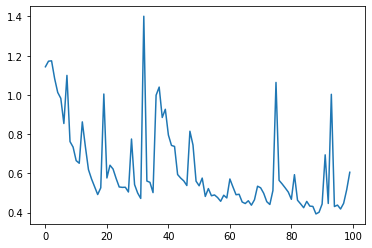

Epoch 1/100
11/11 - 8s - loss: 1.1523 - accuracy: 0.4182 - auc_46: 0.6679 - precision_46: 0.0000e+00 - recall_46: 0.0000e+00 - f1_score: 0.3104 - val_loss: 1.0093 - val_accuracy: 0.5833 - val_auc_46: 0.8011 - val_precision_46: 0.0000e+00 - val_recall_46: 0.0000e+00 - val_f1_score: 0.2456 - 8s/epoch - 772ms/step
Epoch 2/100
11/11 - 1s - loss: 1.0955 - accuracy: 0.5576 - auc_46: 0.7684 - precision_46: 1.0000 - recall_46: 0.0121 - f1_score: 0.4215 - val_loss: 1.0347 - val_accuracy: 0.6667 - val_auc_46: 0.7789 - val_precision_46: 0.0000e+00 - val_recall_46: 0.0000e+00 - val_f1_score: 0.3897 - 1s/epoch - 118ms/step
Epoch 3/100
11/11 - 1s - loss: 1.0714 - accuracy: 0.4667 - auc_46: 0.7099 - precision_46: 0.7778 - recall_46: 0.0212 - f1_score: 0.3309 - val_loss: 1.0519 - val_accuracy: 0.5556 - val_auc_46: 0.7980 - val_precision_46: 0.0000e+00 - val_recall_46: 0.0000e+00 - val_f1_score: 0.2381 - 1s/epoch - 117ms/step
Epoch 4/100
11/11 - 1s - loss: 1.0742 - accuracy: 0.4848 - auc_46: 0.7602 - p

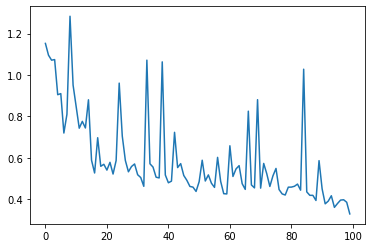

Epoch 1/100
11/11 - 8s - loss: 1.1887 - accuracy: 0.4424 - auc_47: 0.7141 - precision_47: 0.0000e+00 - recall_47: 0.0000e+00 - f1_score: 0.2968 - val_loss: 1.0184 - val_accuracy: 0.6389 - val_auc_47: 0.8301 - val_precision_47: 0.0000e+00 - val_recall_47: 0.0000e+00 - val_f1_score: 0.2599 - 8s/epoch - 770ms/step
Epoch 2/100
11/11 - 1s - loss: 1.1540 - accuracy: 0.5576 - auc_47: 0.7729 - precision_47: 0.3333 - recall_47: 0.0030 - f1_score: 0.3716 - val_loss: 1.0411 - val_accuracy: 0.6389 - val_auc_47: 0.8258 - val_precision_47: 0.0000e+00 - val_recall_47: 0.0000e+00 - val_f1_score: 0.2599 - 1s/epoch - 117ms/step
Epoch 3/100
11/11 - 1s - loss: 1.1258 - accuracy: 0.5394 - auc_47: 0.7840 - precision_47: 0.7000 - recall_47: 0.0212 - f1_score: 0.4720 - val_loss: 1.0622 - val_accuracy: 0.6111 - val_auc_47: 0.7145 - val_precision_47: 0.0000e+00 - val_recall_47: 0.0000e+00 - val_f1_score: 0.2529 - 1s/epoch - 118ms/step
Epoch 4/100
11/11 - 1s - loss: 1.0830 - accuracy: 0.5364 - auc_47: 0.7794 - p

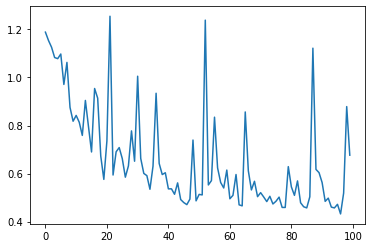

Epoch 1/100
11/11 - 8s - loss: 1.0011 - accuracy: 0.4515 - auc_48: 0.7309 - precision_48: 0.0000e+00 - recall_48: 0.0000e+00 - f1_score: 0.3005 - val_loss: 0.9666 - val_accuracy: 0.5833 - val_auc_48: 0.7560 - val_precision_48: 0.0000e+00 - val_recall_48: 0.0000e+00 - val_f1_score: 0.2456 - 8s/epoch - 771ms/step
Epoch 2/100
11/11 - 1s - loss: 1.0311 - accuracy: 0.5152 - auc_48: 0.7700 - precision_48: 0.6000 - recall_48: 0.0091 - f1_score: 0.3391 - val_loss: 0.9958 - val_accuracy: 0.5833 - val_auc_48: 0.7629 - val_precision_48: 1.0000 - val_recall_48: 0.0278 - val_f1_score: 0.2456 - 1s/epoch - 118ms/step
Epoch 3/100
11/11 - 1s - loss: 0.9691 - accuracy: 0.5606 - auc_48: 0.7889 - precision_48: 0.7368 - recall_48: 0.0424 - f1_score: 0.3707 - val_loss: 1.0412 - val_accuracy: 0.5278 - val_auc_48: 0.7683 - val_precision_48: 1.0000 - val_recall_48: 0.0278 - val_f1_score: 0.2303 - 1s/epoch - 118ms/step
Epoch 4/100
11/11 - 1s - loss: 0.8248 - accuracy: 0.5394 - auc_48: 0.7823 - precision_48: 0.7

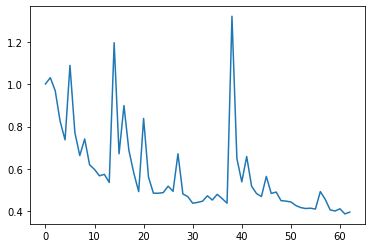

Epoch 1/100
11/11 - 9s - loss: 1.1468 - accuracy: 0.1394 - auc_49: 0.3317 - precision_49: 0.0000e+00 - recall_49: 0.0000e+00 - f1_score: 0.1412 - val_loss: 1.0765 - val_accuracy: 0.6111 - val_auc_49: 0.7874 - val_precision_49: 0.0000e+00 - val_recall_49: 0.0000e+00 - val_f1_score: 0.3857 - 9s/epoch - 776ms/step
Epoch 2/100
11/11 - 1s - loss: 1.1479 - accuracy: 0.4848 - auc_49: 0.7362 - precision_49: 0.0000e+00 - recall_49: 0.0000e+00 - f1_score: 0.3282 - val_loss: 1.0916 - val_accuracy: 0.6111 - val_auc_49: 0.6088 - val_precision_49: 0.0000e+00 - val_recall_49: 0.0000e+00 - val_f1_score: 0.2573 - 1s/epoch - 118ms/step
Epoch 3/100
11/11 - 1s - loss: 1.0724 - accuracy: 0.5667 - auc_49: 0.7694 - precision_49: 0.0000e+00 - recall_49: 0.0000e+00 - f1_score: 0.3493 - val_loss: 1.1147 - val_accuracy: 0.1111 - val_auc_49: 0.3611 - val_precision_49: 0.0000e+00 - val_recall_49: 0.0000e+00 - val_f1_score: 0.0860 - 1s/epoch - 117ms/step
Epoch 4/100
11/11 - 1s - loss: 1.1395 - accuracy: 0.4818 - au

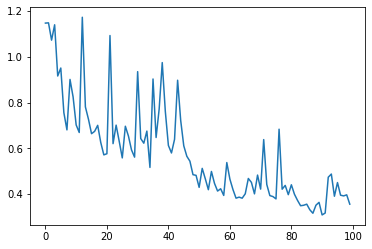

In [48]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []
val_accuracy = 0.0
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    cnnlstm_intensity_earlyfusion_model = CNNLSTM(n_features, n_length, n_outputs, multiclass=True)
    history = cnnlstm_intensity_earlyfusion_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=32, class_weight=d_class_weights)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        cnnlstm_intensity_earlyfusion_model.save(model_path / 'early_intensity_cnnlstm.h5')

#### Training performance and variance

In [49]:
early_cnnlstm_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
early_cnnlstm_train_results

{'Accuracy': 0.6924564719200135,
 'ROC/AUC': 0.8699816823005676,
 'Precision': 0.7010341644287109,
 'Recall': 0.6778815507888794,
 'F1-score': 0.5662882566452027}

In [50]:
early_cnnlstm_train_var = {'Accuracy': np.var(acc), 'ROC/AUC': np.var(auc), 'Precision': np.var(precision), 'Recall': np.var(recall), 'F1-score': np.var(f1)}
early_cnnlstm_train_var

{'Accuracy': 0.0033750814282603866,
 'ROC/AUC': 0.0024591162252961853,
 'Precision': 0.0030031605457453733,
 'Recall': 0.00465314821174431,
 'F1-score': 0.006471138130768282}

#### Validation performance and variance

In [51]:
early_cnnlstm_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
early_cnnlstm_val_results

{'Accuracy': 0.5273273319005967,
 'ROC/AUC': 0.7657845735549926,
 'Precision': 0.5318168252706528,
 'Recall': 0.5135885953903199,
 'F1-score': 0.3504906103014946}

In [52]:
early_cnnlstm_val_var = {'Accuracy': np.var(acc_val), 'ROC/AUC': np.var(auc_val), 'Precision': np.var(precision_val), 'Recall': np.var(recall_val), 'F1-score': np.var(f1_val)}
early_cnnlstm_val_var

{'Accuracy': 0.01645138225252784,
 'ROC/AUC': 0.0032620574212982945,
 'Precision': 0.018254281683730555,
 'Recall': 0.014370501687125383,
 'F1-score': 0.008177786352035903}

#### Predictions and performance on test set

In [53]:
cnnlstm_intensity_earlyfusion_model = load_model(model_path / 'early_intensity_cnnlstm.h5')
y_pred = cnnlstm_intensity_earlyfusion_model.predict(X_test)
_, acc, auc, precision, recall, f1 = cnnlstm_intensity_earlyfusion_model.evaluate(X_test, y_test)
cnnlstm_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

8/8 [==============================] - 2s 36ms/step - loss: 0.8604 - accuracy: 0.4589 - auc_40: 0.7252 - precision_40: 0.4612 - recall_40: 0.4372 - f1_score: 0.2788
Accuracy: 45.89% 
ROC/AUC: 0.73 
Precision: 0.46 
Recall: 0.44 
F1 score: 0.28


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

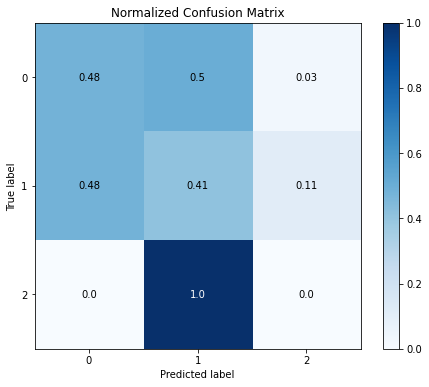

In [54]:
skplt.metrics.plot_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize=True, figsize=(8,6))

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

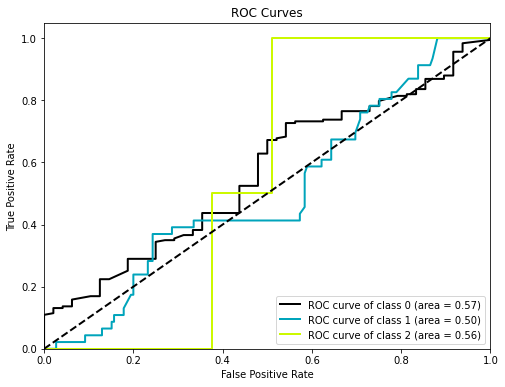

In [55]:
skplt.metrics.plot_roc(y_test.argmax(axis=1), y_pred, plot_micro=False, plot_macro=False, figsize=(8,6))

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

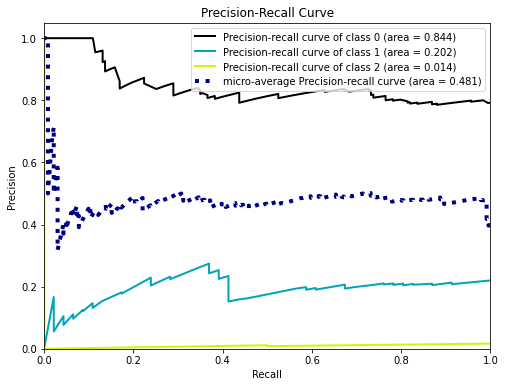

In [56]:
skplt.metrics.plot_precision_recall_curve(y_test.argmax(axis=1), y_pred, figsize=(8,6))

### 3.2 RCNN

Epoch 1/100
11/11 - 3s - loss: 2.0149 - accuracy: 0.4863 - auc_50: 0.6859 - precision_50: 0.5227 - recall_50: 0.2796 - f1_score: 0.3235 - val_loss: 1.0446 - val_accuracy: 0.4595 - val_auc_50: 0.7239 - val_precision_50: 1.0000 - val_recall_50: 0.0270 - val_f1_score: 0.2099 - 3s/epoch - 237ms/step
Epoch 2/100
11/11 - 0s - loss: 1.1865 - accuracy: 0.3921 - auc_50: 0.5736 - precision_50: 0.4615 - recall_50: 0.0912 - f1_score: 0.2578 - val_loss: 1.0291 - val_accuracy: 0.4595 - val_auc_50: 0.7210 - val_precision_50: 1.0000 - val_recall_50: 0.0270 - val_f1_score: 0.2099 - 315ms/epoch - 29ms/step
Epoch 3/100
11/11 - 0s - loss: 0.9741 - accuracy: 0.4286 - auc_50: 0.6163 - precision_50: 0.5385 - recall_50: 0.0851 - f1_score: 0.3242 - val_loss: 0.9556 - val_accuracy: 0.4595 - val_auc_50: 0.7239 - val_precision_50: 1.0000 - val_recall_50: 0.0270 - val_f1_score: 0.2099 - 312ms/epoch - 28ms/step
Epoch 4/100
11/11 - 0s - loss: 1.3966 - accuracy: 0.4468 - auc_50: 0.5997 - precision_50: 0.4204 - recall

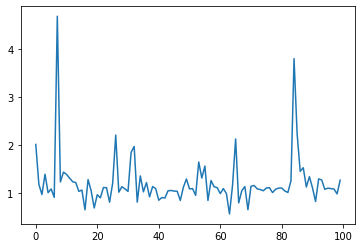

Epoch 1/100
11/11 - 3s - loss: 1.3716 - accuracy: 0.4498 - auc_51: 0.6474 - precision_51: 0.4968 - recall_51: 0.2340 - f1_score: 0.3237 - val_loss: 1.6808 - val_accuracy: 0.3784 - val_auc_51: 0.3822 - val_precision_51: 0.5000 - val_recall_51: 0.0270 - val_f1_score: 0.1830 - 3s/epoch - 241ms/step
Epoch 2/100
11/11 - 0s - loss: 5.7409 - accuracy: 0.1976 - auc_51: 0.4282 - precision_51: 0.2150 - recall_51: 0.1398 - f1_score: 0.1893 - val_loss: 2.9031 - val_accuracy: 0.0000e+00 - val_auc_51: 0.3066 - val_precision_51: 0.0000e+00 - val_recall_51: 0.0000e+00 - val_f1_score: 0.0000e+00 - 302ms/epoch - 27ms/step
Epoch 3/100
11/11 - 0s - loss: 1.4637 - accuracy: 0.1733 - auc_51: 0.4064 - precision_51: 0.2035 - recall_51: 0.1064 - f1_score: 0.1701 - val_loss: 1.4335 - val_accuracy: 0.3514 - val_auc_51: 0.3787 - val_precision_51: 0.5000 - val_recall_51: 0.0270 - val_f1_score: 0.1969 - 315ms/epoch - 29ms/step
Epoch 4/100
11/11 - 0s - loss: 1.2642 - accuracy: 0.3739 - auc_51: 0.5690 - precision_51:

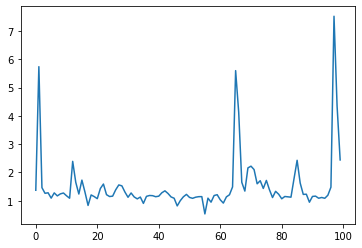

Epoch 1/100
11/11 - 3s - loss: 1.5247 - accuracy: 0.3526 - auc_52: 0.5735 - precision_52: 0.4160 - recall_52: 0.1581 - f1_score: 0.2633 - val_loss: 1.1400 - val_accuracy: 0.4865 - val_auc_52: 0.7199 - val_precision_52: 0.0000e+00 - val_recall_52: 0.0000e+00 - val_f1_score: 0.2182 - 3s/epoch - 286ms/step
Epoch 2/100
11/11 - 0s - loss: 3.5980 - accuracy: 0.2462 - auc_52: 0.4405 - precision_52: 0.2269 - recall_52: 0.1489 - f1_score: 0.2206 - val_loss: 1.4065 - val_accuracy: 0.0000e+00 - val_auc_52: 0.2865 - val_precision_52: 0.0000e+00 - val_recall_52: 0.0000e+00 - val_f1_score: 0.0000e+00 - 296ms/epoch - 27ms/step
Epoch 3/100
11/11 - 0s - loss: 2.1739 - accuracy: 0.1641 - auc_52: 0.3746 - precision_52: 0.2656 - recall_52: 0.1033 - f1_score: 0.1713 - val_loss: 1.4485 - val_accuracy: 0.4865 - val_auc_52: 0.7148 - val_precision_52: 0.0000e+00 - val_recall_52: 0.0000e+00 - val_f1_score: 0.2264 - 304ms/epoch - 28ms/step
Epoch 4/100
11/11 - 0s - loss: 1.2863 - accuracy: 0.4316 - auc_52: 0.6609

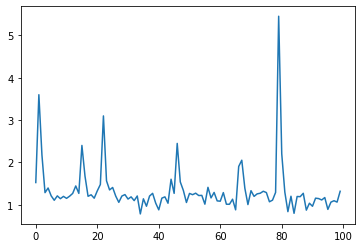

Epoch 1/100
11/11 - 3s - loss: 1.3883 - accuracy: 0.4650 - auc_53: 0.6025 - precision_53: 0.4771 - recall_53: 0.1581 - f1_score: 0.3436 - val_loss: 1.7202 - val_accuracy: 0.5676 - val_auc_53: 0.7237 - val_precision_53: 0.5000 - val_recall_53: 0.0270 - val_f1_score: 0.2414 - 3s/epoch - 237ms/step
Epoch 2/100
11/11 - 0s - loss: 1.4850 - accuracy: 0.3708 - auc_53: 0.5544 - precision_53: 0.3228 - recall_53: 0.1854 - f1_score: 0.2684 - val_loss: 1.5783 - val_accuracy: 0.5676 - val_auc_53: 0.6229 - val_precision_53: 0.5000 - val_recall_53: 0.0270 - val_f1_score: 0.2414 - 312ms/epoch - 28ms/step
Epoch 3/100
11/11 - 0s - loss: 1.4355 - accuracy: 0.2036 - auc_53: 0.4320 - precision_53: 0.3153 - recall_53: 0.1064 - f1_score: 0.1895 - val_loss: 1.3644 - val_accuracy: 0.3784 - val_auc_53: 0.4145 - val_precision_53: 0.5000 - val_recall_53: 0.0270 - val_f1_score: 0.2216 - 313ms/epoch - 28ms/step
Epoch 4/100
11/11 - 0s - loss: 1.3115 - accuracy: 0.2158 - auc_53: 0.4609 - precision_53: 0.2640 - recall

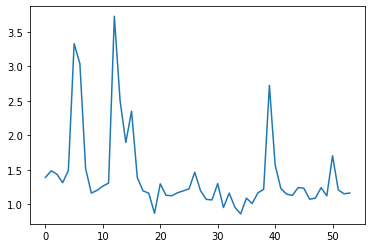

Epoch 1/100
11/11 - 3s - loss: 1.3319 - accuracy: 0.4742 - auc_54: 0.6975 - precision_54: 0.3947 - recall_54: 0.1824 - f1_score: 0.3160 - val_loss: 0.9987 - val_accuracy: 0.4595 - val_auc_54: 0.7148 - val_precision_54: 1.0000 - val_recall_54: 0.0541 - val_f1_score: 0.2369 - 3s/epoch - 240ms/step
Epoch 2/100
11/11 - 0s - loss: 3.6752 - accuracy: 0.4711 - auc_54: 0.7044 - precision_54: 0.5410 - recall_54: 0.3009 - f1_score: 0.3321 - val_loss: 1.9484 - val_accuracy: 0.4865 - val_auc_54: 0.6536 - val_precision_54: 0.0000e+00 - val_recall_54: 0.0000e+00 - val_f1_score: 0.3206 - 308ms/epoch - 28ms/step
Epoch 3/100
11/11 - 0s - loss: 1.7984 - accuracy: 0.3921 - auc_54: 0.5606 - precision_54: 0.3542 - recall_54: 0.1550 - f1_score: 0.2965 - val_loss: 1.4220 - val_accuracy: 0.5405 - val_auc_54: 0.7252 - val_precision_54: 0.0000e+00 - val_recall_54: 0.0000e+00 - val_f1_score: 0.2339 - 306ms/epoch - 28ms/step
Epoch 4/100
11/11 - 0s - loss: 1.2734 - accuracy: 0.4103 - auc_54: 0.6039 - precision_54:

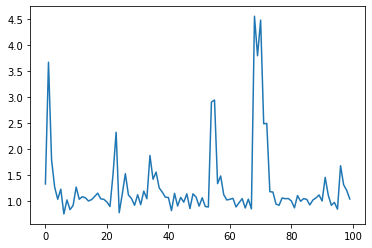

Epoch 1/100
11/11 - 3s - loss: 2.1443 - accuracy: 0.4498 - auc_55: 0.6459 - precision_55: 0.4536 - recall_55: 0.2675 - f1_score: 0.3199 - val_loss: 0.9957 - val_accuracy: 0.6216 - val_auc_55: 0.8223 - val_precision_55: 1.0000 - val_recall_55: 0.0541 - val_f1_score: 0.2556 - 3s/epoch - 235ms/step
Epoch 2/100
11/11 - 0s - loss: 1.2456 - accuracy: 0.3131 - auc_55: 0.5533 - precision_55: 0.5513 - recall_55: 0.1307 - f1_score: 0.2528 - val_loss: 1.6295 - val_accuracy: 0.4054 - val_auc_55: 0.6653 - val_precision_55: 0.5000 - val_recall_55: 0.0270 - val_f1_score: 0.2144 - 308ms/epoch - 28ms/step
Epoch 3/100
11/11 - 0s - loss: 2.0348 - accuracy: 0.4407 - auc_55: 0.6238 - precision_55: 0.3902 - recall_55: 0.1945 - f1_score: 0.3087 - val_loss: 1.8452 - val_accuracy: 0.0270 - val_auc_55: 0.2191 - val_precision_55: 0.5000 - val_recall_55: 0.0270 - val_f1_score: 0.0278 - 299ms/epoch - 27ms/step
Epoch 4/100
11/11 - 0s - loss: 1.5259 - accuracy: 0.1884 - auc_55: 0.3695 - precision_55: 0.2043 - recall

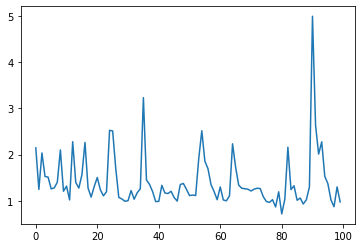

Epoch 1/100
11/11 - 3s - loss: 1.6053 - accuracy: 0.3697 - auc_56: 0.5824 - precision_56: 0.3657 - recall_56: 0.1939 - f1_score: 0.2841 - val_loss: 2.8689 - val_accuracy: 0.5833 - val_auc_56: 0.5808 - val_precision_56: 0.0000e+00 - val_recall_56: 0.0000e+00 - val_f1_score: 0.2456 - 3s/epoch - 275ms/step
Epoch 2/100
11/11 - 0s - loss: 2.6639 - accuracy: 0.2455 - auc_56: 0.4251 - precision_56: 0.2270 - recall_56: 0.1273 - f1_score: 0.2250 - val_loss: 1.0975 - val_accuracy: 0.4167 - val_auc_56: 0.4543 - val_precision_56: 1.0000 - val_recall_56: 0.0278 - val_f1_score: 0.1961 - 310ms/epoch - 28ms/step
Epoch 3/100
11/11 - 0s - loss: 1.8785 - accuracy: 0.3939 - auc_56: 0.5750 - precision_56: 0.4370 - recall_56: 0.1576 - f1_score: 0.3134 - val_loss: 1.9337 - val_accuracy: 0.3889 - val_auc_56: 0.6827 - val_precision_56: 0.0000e+00 - val_recall_56: 0.0000e+00 - val_f1_score: 0.1867 - 297ms/epoch - 27ms/step
Epoch 4/100
11/11 - 0s - loss: 1.2603 - accuracy: 0.5242 - auc_56: 0.7222 - precision_56:

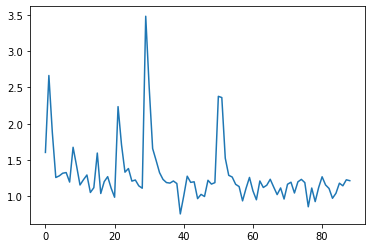

Epoch 1/100
11/11 - 3s - loss: 1.6026 - accuracy: 0.3848 - auc_57: 0.5833 - precision_57: 0.4225 - recall_57: 0.0909 - f1_score: 0.2738 - val_loss: 5.4107 - val_accuracy: 0.3611 - val_auc_57: 0.3709 - val_precision_57: 0.0000e+00 - val_recall_57: 0.0000e+00 - val_f1_score: 0.1884 - 3s/epoch - 238ms/step
Epoch 2/100
11/11 - 0s - loss: 1.1969 - accuracy: 0.5576 - auc_57: 0.7117 - precision_57: 0.5449 - recall_57: 0.2758 - f1_score: 0.3961 - val_loss: 2.4969 - val_accuracy: 0.5556 - val_auc_57: 0.7141 - val_precision_57: 0.0000e+00 - val_recall_57: 0.0000e+00 - val_f1_score: 0.2381 - 314ms/epoch - 29ms/step
Epoch 3/100
11/11 - 0s - loss: 1.2765 - accuracy: 0.3939 - auc_57: 0.6039 - precision_57: 0.4560 - recall_57: 0.1727 - f1_score: 0.2954 - val_loss: 0.9762 - val_accuracy: 0.6389 - val_auc_57: 0.8108 - val_precision_57: 1.0000 - val_recall_57: 0.0833 - val_f1_score: 0.2599 - 312ms/epoch - 28ms/step
Epoch 4/100
11/11 - 0s - loss: 1.6327 - accuracy: 0.2273 - auc_57: 0.4129 - precision_57:

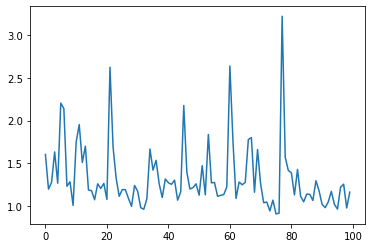

Epoch 1/100
11/11 - 3s - loss: 1.2078 - accuracy: 0.3091 - auc_58: 0.5279 - precision_58: 0.4667 - recall_58: 0.1273 - f1_score: 0.2388 - val_loss: 2.0259 - val_accuracy: 0.3889 - val_auc_58: 0.6900 - val_precision_58: 0.0000e+00 - val_recall_58: 0.0000e+00 - val_f1_score: 0.1867 - 3s/epoch - 241ms/step
Epoch 2/100
11/11 - 0s - loss: 3.3137 - accuracy: 0.4394 - auc_58: 0.6582 - precision_58: 0.4390 - recall_58: 0.2727 - f1_score: 0.3156 - val_loss: 1.2235 - val_accuracy: 0.3333 - val_auc_58: 0.3212 - val_precision_58: 0.0000e+00 - val_recall_58: 0.0000e+00 - val_f1_score: 0.1951 - 307ms/epoch - 28ms/step
Epoch 3/100
11/11 - 0s - loss: 1.0917 - accuracy: 0.4333 - auc_58: 0.6483 - precision_58: 0.4667 - recall_58: 0.1485 - f1_score: 0.2905 - val_loss: 1.0601 - val_accuracy: 0.4167 - val_auc_58: 0.6165 - val_precision_58: 1.0000 - val_recall_58: 0.0278 - val_f1_score: 0.2208 - 308ms/epoch - 28ms/step
Epoch 4/100
11/11 - 0s - loss: 1.2745 - accuracy: 0.3970 - auc_58: 0.6403 - precision_58:

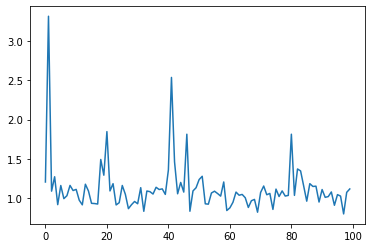

Epoch 1/100
11/11 - 3s - loss: 3.6771 - accuracy: 0.4152 - auc_59: 0.6464 - precision_59: 0.3935 - recall_59: 0.3303 - f1_score: 0.2890 - val_loss: 1.3690 - val_accuracy: 0.3611 - val_auc_59: 0.6593 - val_precision_59: 0.0000e+00 - val_recall_59: 0.0000e+00 - val_f1_score: 0.1806 - 3s/epoch - 235ms/step
Epoch 2/100
11/11 - 0s - loss: 1.2836 - accuracy: 0.4970 - auc_59: 0.6876 - precision_59: 0.3929 - recall_59: 0.0667 - f1_score: 0.3826 - val_loss: 1.0035 - val_accuracy: 0.6389 - val_auc_59: 0.8245 - val_precision_59: 1.0000 - val_recall_59: 0.0278 - val_f1_score: 0.2599 - 311ms/epoch - 28ms/step
Epoch 3/100
11/11 - 0s - loss: 1.4247 - accuracy: 0.3545 - auc_59: 0.5638 - precision_59: 0.3182 - recall_59: 0.1061 - f1_score: 0.2780 - val_loss: 1.0098 - val_accuracy: 0.5833 - val_auc_59: 0.7637 - val_precision_59: 1.0000 - val_recall_59: 0.0278 - val_f1_score: 0.3472 - 309ms/epoch - 28ms/step
Epoch 4/100
11/11 - 0s - loss: 1.3153 - accuracy: 0.2758 - auc_59: 0.4806 - precision_59: 0.2794 

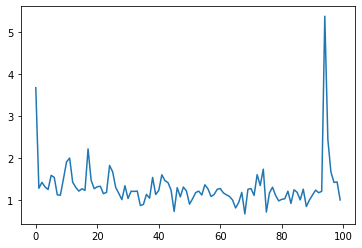

In [57]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []
val_accuracy = 0.0
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    rcnn_intensity_earlyfusion_model = RCNN(n_features, n_length, n_outputs, multiclass=True)
    history = rcnn_intensity_earlyfusion_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=32, class_weight=d_class_weights)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        rcnn_intensity_earlyfusion_model.save(model_path / 'early_intensity_rcnn.h5')

#### Training performance and variance

In [58]:
early_rcnn_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
early_rcnn_train_results

{'Accuracy': 0.33750022798776624,
 'ROC/AUC': 0.5776164501905441,
 'Precision': 0.48448801338672637,
 'Recall': 0.139671178907156,
 'F1-score': 0.27142043560743334}

In [59]:
early_rcnn_train_var = {'Accuracy': np.var(acc), 'ROC/AUC': np.var(auc), 'Precision': np.var(precision), 'Recall': np.var(recall), 'F1-score': np.var(f1)}
early_rcnn_train_var

{'Accuracy': 0.028241419361723818,
 'ROC/AUC': 0.020220651750269956,
 'Precision': 0.05140367969834138,
 'Recall': 0.0020161584093961746,
 'F1-score': 0.012800739539798985}

#### Validation performance and variance

In [60]:
early_rcnn_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
early_rcnn_val_results

{'Accuracy': 0.42657657731324433,
 'ROC/AUC': 0.6957217425107955,
 'Precision': 0.6433183193206787,
 'Recall': 0.1650150164961815,
 'F1-score': 0.20310979019850492}

In [61]:
early_rcnn_val_var = {'Accuracy': np.var(acc_val), 'ROC/AUC': np.var(auc_val), 'Precision': np.var(precision_val), 'Recall': np.var(recall_val), 'F1-score': np.var(f1_val)}
early_rcnn_val_var

{'Accuracy': 0.023770257236539236,
 'ROC/AUC': 0.01600699871751069,
 'Precision': 0.10851825342440849,
 'Recall': 0.04602742447155753,
 'F1-score': 0.003827727374803134}

#### Predictions and performance on test set

In [62]:
rcnn_intensity_earlyfusion_model = load_model(model_path / 'early_intensity_rcnn.h5')
y_pred = rcnn_intensity_earlyfusion_model.predict(X_test)
_, acc, auc, precision, recall, f1 = rcnn_intensity_earlyfusion_model.evaluate(X_test, y_test)
rcnn_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

8/8 [==============================] - 1s 11ms/step - loss: 0.7002 - accuracy: 0.7922 - auc_57: 0.8946 - precision_57: 0.7922 - recall_57: 0.7922 - f1_score: 0.2947
Accuracy: 79.22% 
ROC/AUC: 0.89 
Precision: 0.79 
Recall: 0.79 
F1 score: 0.29


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

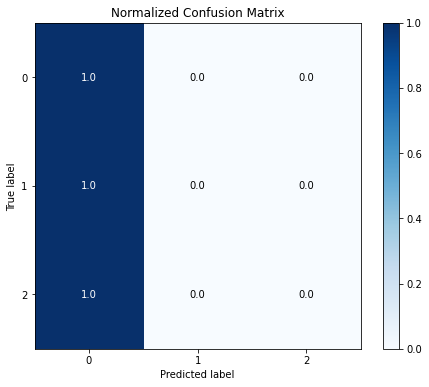

In [63]:
skplt.metrics.plot_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize=True, figsize=(8,6))

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

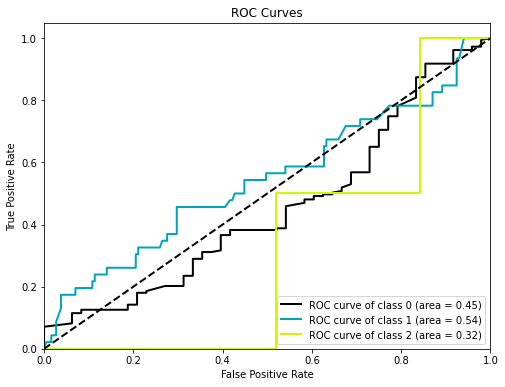

In [64]:
skplt.metrics.plot_roc(y_test.argmax(axis=1), y_pred, plot_micro=False, plot_macro=False, figsize=(8,6))

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

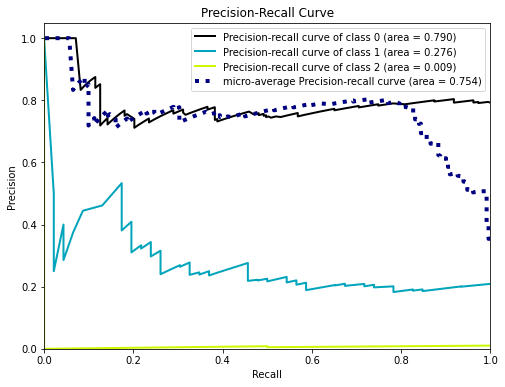

In [65]:
skplt.metrics.plot_precision_recall_curve(y_test.argmax(axis=1), y_pred, figsize=(8,6))

## 4. Multimodal Late Fusion

In [66]:
body_X_train, body_X_test, body_y_train, body_y_test = load_dataset('skeleton', level=True, fusion=True, nopain=False)
body_X = body_X_train.copy()
body_y = body_y_train.copy()

print(body_X_train.shape, body_y_train.shape)
print(body_X_test.shape, body_y_test.shape)

(366, 1, 350, 35) (366, 3)
(231, 1, 350, 35) (231, 3)


In [67]:
face_X_train, face_X_test, face_y_train, face_y_test = load_dataset('AUs', level=True, nopain=False)
face_X = face_X_train.copy()
face_y = face_y_train.copy()

print(face_X_train.shape, face_y_train.shape)
print(face_X_test.shape, face_y_test.shape)

(366, 1, 350, 25) (366, 3)
(231, 1, 350, 25) (231, 3)


In [68]:
n_length, body_features, face_features, n_outputs = face_X_train.shape[2], body_X_train.shape[-1], face_X_train.shape[-1], body_y_train.shape[1]

### 4.1 CNN + BiLSTM (Concatenation)

Epoch 1/100
11/11 - 15s - loss: 1.0289 - accuracy: 0.5714 - auc_60: 0.7760 - precision_60: 0.4500 - recall_60: 0.0274 - f1_score: 0.3183 - val_loss: 0.9543 - val_accuracy: 0.5135 - val_auc_60: 0.7243 - val_precision_60: 0.0000e+00 - val_recall_60: 0.0000e+00 - val_f1_score: 0.2814 - 15s/epoch - 1s/step
Epoch 2/100
11/11 - 3s - loss: 1.0793 - accuracy: 0.6170 - auc_60: 0.8147 - precision_60: 0.7812 - recall_60: 0.0760 - f1_score: 0.3661 - val_loss: 0.9712 - val_accuracy: 0.5676 - val_auc_60: 0.7202 - val_precision_60: 0.0000e+00 - val_recall_60: 0.0000e+00 - val_f1_score: 0.3556 - 3s/epoch - 231ms/step
Epoch 3/100
11/11 - 3s - loss: 0.9329 - accuracy: 0.6140 - auc_60: 0.8222 - precision_60: 0.8182 - recall_60: 0.0274 - f1_score: 0.4016 - val_loss: 0.9534 - val_accuracy: 0.4595 - val_auc_60: 0.7034 - val_precision_60: 0.0000e+00 - val_recall_60: 0.0000e+00 - val_f1_score: 0.2099 - 3s/epoch - 234ms/step
Epoch 4/100
11/11 - 3s - loss: 0.8693 - accuracy: 0.6109 - auc_60: 0.8349 - precision_

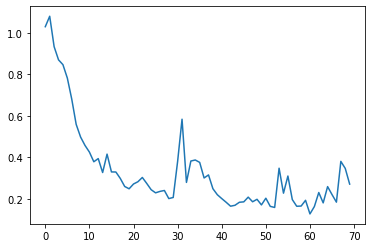

Epoch 1/100
11/11 - 17s - loss: 1.2195 - accuracy: 0.5015 - auc_61: 0.7398 - precision_61: 0.0000e+00 - recall_61: 0.0000e+00 - f1_score: 0.3358 - val_loss: 0.9131 - val_accuracy: 0.6216 - val_auc_61: 0.8402 - val_precision_61: 0.5000 - val_recall_61: 0.0270 - val_f1_score: 0.2556 - 17s/epoch - 2s/step
Epoch 2/100
11/11 - 2s - loss: 1.1625 - accuracy: 0.6140 - auc_61: 0.8111 - precision_61: 0.8333 - recall_61: 0.0152 - f1_score: 0.4064 - val_loss: 0.9148 - val_accuracy: 0.6216 - val_auc_61: 0.8137 - val_precision_61: 0.5000 - val_recall_61: 0.0270 - val_f1_score: 0.2556 - 2s/epoch - 213ms/step
Epoch 3/100
11/11 - 2s - loss: 1.0863 - accuracy: 0.6109 - auc_61: 0.8103 - precision_61: 0.6842 - recall_61: 0.0395 - f1_score: 0.4936 - val_loss: 0.8706 - val_accuracy: 0.6216 - val_auc_61: 0.8198 - val_precision_61: 0.5000 - val_recall_61: 0.0270 - val_f1_score: 0.2556 - 2s/epoch - 216ms/step
Epoch 4/100
11/11 - 2s - loss: 0.9558 - accuracy: 0.6201 - auc_61: 0.8119 - precision_61: 0.7500 - rec

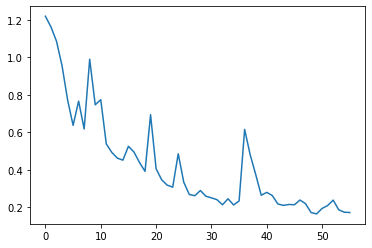

Epoch 1/100
11/11 - 15s - loss: 1.1520 - accuracy: 0.4316 - auc_62: 0.6861 - precision_62: 0.0000e+00 - recall_62: 0.0000e+00 - f1_score: 0.2904 - val_loss: 0.9762 - val_accuracy: 0.5135 - val_auc_62: 0.8026 - val_precision_62: 0.0000e+00 - val_recall_62: 0.0000e+00 - val_f1_score: 0.3402 - 15s/epoch - 1s/step
Epoch 2/100
11/11 - 2s - loss: 1.1295 - accuracy: 0.5228 - auc_62: 0.7665 - precision_62: 0.0000e+00 - recall_62: 0.0000e+00 - f1_score: 0.3583 - val_loss: 0.9886 - val_accuracy: 0.4865 - val_auc_62: 0.7772 - val_precision_62: 0.0000e+00 - val_recall_62: 0.0000e+00 - val_f1_score: 0.2182 - 2s/epoch - 208ms/step
Epoch 3/100
11/11 - 2s - loss: 1.1105 - accuracy: 0.5562 - auc_62: 0.7731 - precision_62: 0.6000 - recall_62: 0.0182 - f1_score: 0.3791 - val_loss: 1.0042 - val_accuracy: 0.5135 - val_auc_62: 0.7891 - val_precision_62: 0.0000e+00 - val_recall_62: 0.0000e+00 - val_f1_score: 0.2262 - 2s/epoch - 207ms/step
Epoch 4/100
11/11 - 2s - loss: 0.9778 - accuracy: 0.6201 - auc_62: 0.8

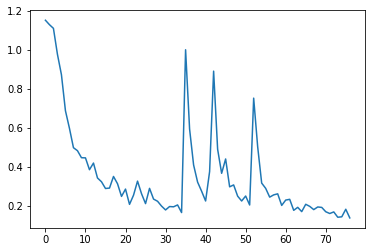

Epoch 1/100
11/11 - 15s - loss: 1.1155 - accuracy: 0.2188 - auc_63: 0.4209 - precision_63: 0.0000e+00 - recall_63: 0.0000e+00 - f1_score: 0.2077 - val_loss: 0.9927 - val_accuracy: 0.5676 - val_auc_63: 0.7818 - val_precision_63: 0.0000e+00 - val_recall_63: 0.0000e+00 - val_f1_score: 0.2414 - 15s/epoch - 1s/step
Epoch 2/100
11/11 - 2s - loss: 1.1445 - accuracy: 0.5684 - auc_63: 0.7906 - precision_63: 1.0000 - recall_63: 0.0122 - f1_score: 0.3590 - val_loss: 0.9525 - val_accuracy: 0.5676 - val_auc_63: 0.7927 - val_precision_63: 0.0000e+00 - val_recall_63: 0.0000e+00 - val_f1_score: 0.2414 - 2s/epoch - 210ms/step
Epoch 3/100
11/11 - 2s - loss: 0.9420 - accuracy: 0.5258 - auc_63: 0.7599 - precision_63: 0.7273 - recall_63: 0.0243 - f1_score: 0.4082 - val_loss: 0.8498 - val_accuracy: 0.5676 - val_auc_63: 0.7936 - val_precision_63: 0.0000e+00 - val_recall_63: 0.0000e+00 - val_f1_score: 0.2414 - 2s/epoch - 213ms/step
Epoch 4/100
11/11 - 2s - loss: 0.8685 - accuracy: 0.6170 - auc_63: 0.8172 - pr

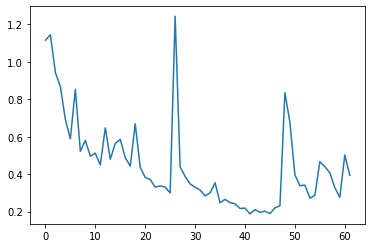

Epoch 1/100
11/11 - 16s - loss: 1.1437 - accuracy: 0.4863 - auc_64: 0.7351 - precision_64: 0.7500 - recall_64: 0.0091 - f1_score: 0.3294 - val_loss: 0.9242 - val_accuracy: 0.5405 - val_auc_64: 0.7306 - val_precision_64: 0.2500 - val_recall_64: 0.0270 - val_f1_score: 0.2339 - 16s/epoch - 1s/step
Epoch 2/100
11/11 - 3s - loss: 0.9693 - accuracy: 0.6687 - auc_64: 0.8456 - precision_64: 0.7778 - recall_64: 0.1489 - f1_score: 0.4235 - val_loss: 0.9187 - val_accuracy: 0.5405 - val_auc_64: 0.7252 - val_precision_64: 0.3571 - val_recall_64: 0.1351 - val_f1_score: 0.2339 - 3s/epoch - 236ms/step
Epoch 3/100
11/11 - 3s - loss: 0.8889 - accuracy: 0.6748 - auc_64: 0.8482 - precision_64: 0.7571 - recall_64: 0.1611 - f1_score: 0.6158 - val_loss: 0.9051 - val_accuracy: 0.5405 - val_auc_64: 0.7270 - val_precision_64: 0.5405 - val_recall_64: 0.5405 - val_f1_score: 0.2339 - 3s/epoch - 234ms/step
Epoch 4/100
11/11 - 3s - loss: 0.7780 - accuracy: 0.6261 - auc_64: 0.8408 - precision_64: 0.7044 - recall_64: 

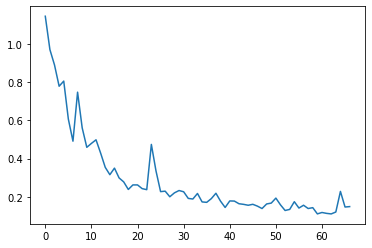

Epoch 1/100
11/11 - 16s - loss: 1.1528 - accuracy: 0.4742 - auc_65: 0.7418 - precision_65: 0.0000e+00 - recall_65: 0.0000e+00 - f1_score: 0.3232 - val_loss: 0.9462 - val_accuracy: 0.6216 - val_auc_65: 0.7966 - val_precision_65: 1.0000 - val_recall_65: 0.0270 - val_f1_score: 0.2556 - 16s/epoch - 1s/step
Epoch 2/100
11/11 - 3s - loss: 1.0642 - accuracy: 0.5927 - auc_65: 0.8038 - precision_65: 1.0000 - recall_65: 0.0334 - f1_score: 0.4666 - val_loss: 0.9264 - val_accuracy: 0.6216 - val_auc_65: 0.8048 - val_precision_65: 1.0000 - val_recall_65: 0.0541 - val_f1_score: 0.2556 - 3s/epoch - 247ms/step
Epoch 3/100
11/11 - 3s - loss: 0.9831 - accuracy: 0.5623 - auc_65: 0.7865 - precision_65: 0.7143 - recall_65: 0.0760 - f1_score: 0.4359 - val_loss: 0.8951 - val_accuracy: 0.4054 - val_auc_65: 0.7303 - val_precision_65: 1.0000 - val_recall_65: 0.0541 - val_f1_score: 0.2556 - 3s/epoch - 234ms/step
Epoch 4/100
11/11 - 3s - loss: 0.8899 - accuracy: 0.5593 - auc_65: 0.7984 - precision_65: 0.6842 - rec

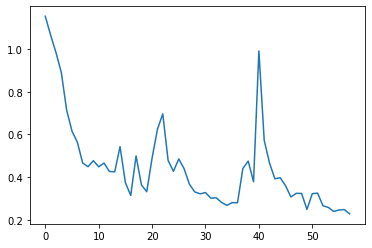

Epoch 1/100
11/11 - 16s - loss: 1.2724 - accuracy: 0.4970 - auc_66: 0.7495 - precision_66: 0.0000e+00 - recall_66: 0.0000e+00 - f1_score: 0.3188 - val_loss: 0.9369 - val_accuracy: 0.5833 - val_auc_66: 0.7932 - val_precision_66: 0.0000e+00 - val_recall_66: 0.0000e+00 - val_f1_score: 0.2456 - 16s/epoch - 1s/step
Epoch 2/100
11/11 - 3s - loss: 1.1193 - accuracy: 0.5848 - auc_66: 0.8052 - precision_66: 0.5000 - recall_66: 0.0030 - f1_score: 0.3745 - val_loss: 0.9401 - val_accuracy: 0.5833 - val_auc_66: 0.7652 - val_precision_66: 0.0000e+00 - val_recall_66: 0.0000e+00 - val_f1_score: 0.2456 - 3s/epoch - 231ms/step
Epoch 3/100
11/11 - 3s - loss: 1.0552 - accuracy: 0.5879 - auc_66: 0.8068 - precision_66: 0.6667 - recall_66: 0.0242 - f1_score: 0.4486 - val_loss: 0.8998 - val_accuracy: 0.6389 - val_auc_66: 0.7843 - val_precision_66: 0.0000e+00 - val_recall_66: 0.0000e+00 - val_f1_score: 0.3330 - 3s/epoch - 236ms/step
Epoch 4/100
11/11 - 3s - loss: 1.0309 - accuracy: 0.5788 - auc_66: 0.8184 - pr

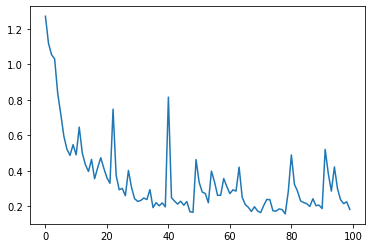

Epoch 1/100
11/11 - 15s - loss: 1.2611 - accuracy: 0.5212 - auc_67: 0.7426 - precision_67: 0.0000e+00 - recall_67: 0.0000e+00 - f1_score: 0.3489 - val_loss: 1.0236 - val_accuracy: 0.3611 - val_auc_67: 0.7016 - val_precision_67: 0.0000e+00 - val_recall_67: 0.0000e+00 - val_f1_score: 0.1769 - 15s/epoch - 1s/step
Epoch 2/100
11/11 - 2s - loss: 1.0884 - accuracy: 0.5848 - auc_67: 0.8058 - precision_67: 1.0000 - recall_67: 0.0030 - f1_score: 0.3934 - val_loss: 1.0418 - val_accuracy: 0.3611 - val_auc_67: 0.7078 - val_precision_67: 0.0000e+00 - val_recall_67: 0.0000e+00 - val_f1_score: 0.1769 - 2s/epoch - 205ms/step
Epoch 3/100
11/11 - 2s - loss: 0.9431 - accuracy: 0.6000 - auc_67: 0.8037 - precision_67: 0.8000 - recall_67: 0.0242 - f1_score: 0.4848 - val_loss: 1.0476 - val_accuracy: 0.4444 - val_auc_67: 0.7485 - val_precision_67: 0.0000e+00 - val_recall_67: 0.0000e+00 - val_f1_score: 0.2917 - 2s/epoch - 208ms/step
Epoch 4/100
11/11 - 2s - loss: 0.8082 - accuracy: 0.6394 - auc_67: 0.8248 - pr

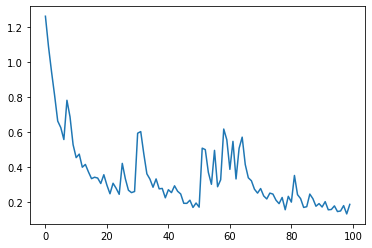

Epoch 1/100
11/11 - 15s - loss: 1.0523 - accuracy: 0.4667 - auc_68: 0.7329 - precision_68: 1.0000 - recall_68: 0.0030 - f1_score: 0.3096 - val_loss: 0.9335 - val_accuracy: 0.5833 - val_auc_68: 0.7814 - val_precision_68: 0.0000e+00 - val_recall_68: 0.0000e+00 - val_f1_score: 0.2456 - 15s/epoch - 1s/step
Epoch 2/100
11/11 - 2s - loss: 0.9364 - accuracy: 0.6091 - auc_68: 0.8167 - precision_68: 0.7500 - recall_68: 0.0273 - f1_score: 0.3968 - val_loss: 0.8969 - val_accuracy: 0.5833 - val_auc_68: 0.7712 - val_precision_68: 1.0000 - val_recall_68: 0.0278 - val_f1_score: 0.2456 - 2s/epoch - 211ms/step
Epoch 3/100
11/11 - 2s - loss: 0.9154 - accuracy: 0.5727 - auc_68: 0.8030 - precision_68: 0.6375 - recall_68: 0.1545 - f1_score: 0.3807 - val_loss: 0.8799 - val_accuracy: 0.5833 - val_auc_68: 0.7822 - val_precision_68: 1.0000 - val_recall_68: 0.1111 - val_f1_score: 0.2456 - 2s/epoch - 214ms/step
Epoch 4/100
11/11 - 2s - loss: 0.7592 - accuracy: 0.6303 - auc_68: 0.8289 - precision_68: 0.6639 - rec

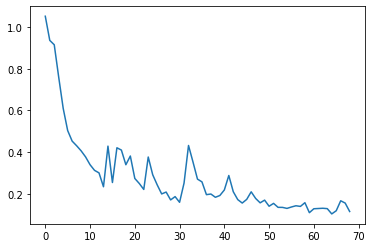

Epoch 1/100
11/11 - 15s - loss: 1.2967 - accuracy: 0.5030 - auc_69: 0.7486 - precision_69: 0.7500 - recall_69: 0.0091 - f1_score: 0.3282 - val_loss: 0.9067 - val_accuracy: 0.7500 - val_auc_69: 0.8854 - val_precision_69: 0.0000e+00 - val_recall_69: 0.0000e+00 - val_f1_score: 0.4522 - 15s/epoch - 1s/step
Epoch 2/100
11/11 - 2s - loss: 1.1034 - accuracy: 0.5212 - auc_69: 0.7813 - precision_69: 0.6667 - recall_69: 0.0061 - f1_score: 0.3370 - val_loss: 0.9346 - val_accuracy: 0.6389 - val_auc_69: 0.8632 - val_precision_69: 0.0000e+00 - val_recall_69: 0.0000e+00 - val_f1_score: 0.4099 - 2s/epoch - 207ms/step
Epoch 3/100
11/11 - 2s - loss: 1.0754 - accuracy: 0.5545 - auc_69: 0.7973 - precision_69: 0.8571 - recall_69: 0.0182 - f1_score: 0.3703 - val_loss: 0.9214 - val_accuracy: 0.6389 - val_auc_69: 0.8474 - val_precision_69: 0.0000e+00 - val_recall_69: 0.0000e+00 - val_f1_score: 0.3018 - 2s/epoch - 209ms/step
Epoch 4/100
11/11 - 2s - loss: 1.0215 - accuracy: 0.6152 - auc_69: 0.8313 - precision_

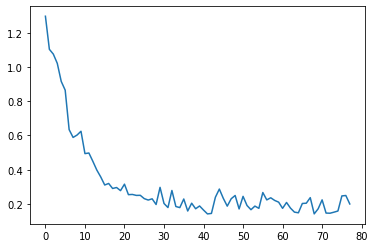

In [69]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []
val_accuracy = 0.0
for train_index, val_index in kf.split(body_X):
    body_X_train, body_X_val = body_X[train_index], body_X[val_index]
    face_X_train, face_X_val = face_X[train_index], face_X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    cnnlstm_intensity_latefusion_model = CNNLSTM_fusioned(body_features, face_features, n_length, n_outputs, multiclass=True)
    history = cnnlstm_intensity_latefusion_model.train(body_X_train, face_X_train, y_train, body_X_val, face_X_val, y_val, epochs=epochs, batch_size=32, class_weight=d_class_weights)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        cnnlstm_intensity_latefusion_model.save(model_path / 'late_intensity_cnnlstm.h5')

#### Training performance and variance

In [70]:
late_cnnlstm_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
late_cnnlstm_train_results

{'Accuracy': 0.8864437699317932,
 'ROC/AUC': 0.9729775249958038,
 'Precision': 0.8890653133392334,
 'Recall': 0.8824924051761627,
 'F1-score': 0.7872697710990906}

In [71]:
late_cnnlstm_train_var = {'Accuracy': np.var(acc), 'ROC/AUC': np.var(auc), 'Precision': np.var(precision), 'Recall': np.var(recall), 'F1-score': np.var(f1)}
late_cnnlstm_train_var

{'Accuracy': 0.001608828392855486,
 'ROC/AUC': 0.0003744486158158011,
 'Precision': 0.0013962393784551354,
 'Recall': 0.002241434378839138,
 'F1-score': 0.007505585755926347}

#### Validation performance and variance

In [72]:
late_cnnlstm_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
late_cnnlstm_val_results

{'Accuracy': 0.637162160873413,
 'ROC/AUC': 0.8148968696594239,
 'Precision': 0.6388138115406037,
 'Recall': 0.6344594597816468,
 'F1-score': 0.4146596431732178}

In [73]:
late_cnnlstm_val_var = {'Accuracy': np.var(acc_val), 'ROC/AUC': np.var(auc_val), 'Precision': np.var(precision_val), 'Recall': np.var(recall_val), 'F1-score': np.var(f1_val)}
late_cnnlstm_val_var

{'Accuracy': 0.007624409108721722,
 'ROC/AUC': 0.002553161243800019,
 'Precision': 0.007008861130913181,
 'Recall': 0.007920245245740318,
 'F1-score': 0.0034966012673473303}

#### Performance and predictions on test set

In [74]:
cnnlstm_intensity_latefusion_model = load_model(model_path / 'late_intensity_cnnlstm.h5')
y_pred = cnnlstm_intensity_latefusion_model.predict([body_X_test, face_X_test])
_, acc, auc, precision, recall, f1 = cnnlstm_intensity_latefusion_model.evaluate([body_X_test, face_X_test], y_test)
cnnlstm_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

8/8 [==============================] - 3s 61ms/step - loss: 1.1146 - accuracy: 0.6017 - auc_66: 0.8168 - precision_66: 0.6017 - recall_66: 0.6017 - f1_score: 0.3107
Accuracy: 60.17% 
ROC/AUC: 0.82 
Precision: 0.60 
Recall: 0.60 
F1 score: 0.31


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

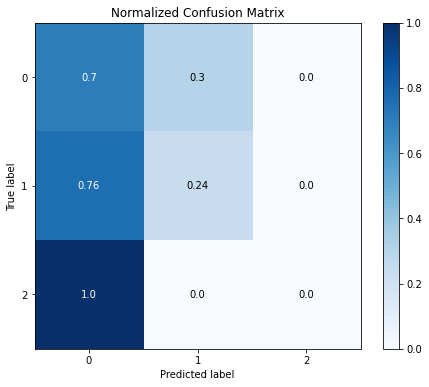

In [75]:
skplt.metrics.plot_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize=True, figsize=(8,6))

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

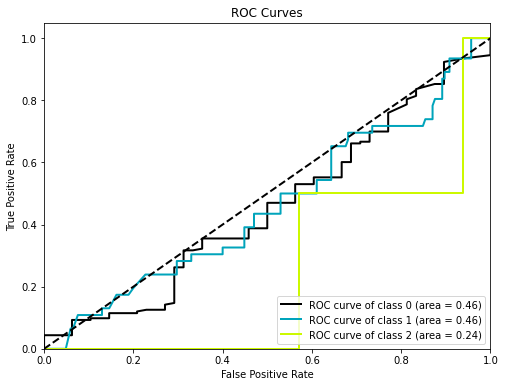

In [76]:
skplt.metrics.plot_roc(y_test.argmax(axis=1), y_pred, plot_micro=False, plot_macro=False, figsize=(8,6))

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

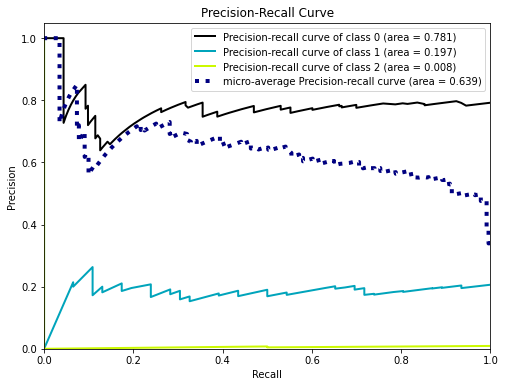

In [77]:
skplt.metrics.plot_precision_recall_curve(y_test.argmax(axis=1), y_pred, figsize=(8,6))

### 4.2 RCNN (Concatenation)

Epoch 1/100
11/11 - 4s - loss: 2.9474 - accuracy: 0.4529 - auc_70: 0.6550 - precision_70: 0.4600 - recall_70: 0.4195 - f1_score: 0.3119 - val_loss: 19.6962 - val_accuracy: 0.4595 - val_auc_70: 0.5946 - val_precision_70: 0.4595 - val_recall_70: 0.4595 - val_f1_score: 0.2099 - 4s/epoch - 365ms/step
Epoch 2/100
11/11 - 0s - loss: 1.6312 - accuracy: 0.5502 - auc_70: 0.7525 - precision_70: 0.5621 - recall_70: 0.4954 - f1_score: 0.3952 - val_loss: 5.2289 - val_accuracy: 0.4324 - val_auc_70: 0.5995 - val_precision_70: 0.4324 - val_recall_70: 0.4324 - val_f1_score: 0.2013 - 464ms/epoch - 42ms/step
Epoch 3/100
11/11 - 0s - loss: 0.8196 - accuracy: 0.5593 - auc_70: 0.7816 - precision_70: 0.5686 - recall_70: 0.5289 - f1_score: 0.4161 - val_loss: 9.3196 - val_accuracy: 0.5135 - val_auc_70: 0.6351 - val_precision_70: 0.5135 - val_recall_70: 0.5135 - val_f1_score: 0.2262 - 463ms/epoch - 42ms/step
Epoch 4/100
11/11 - 0s - loss: 1.0031 - accuracy: 0.4833 - auc_70: 0.7431 - precision_70: 0.4832 - recal

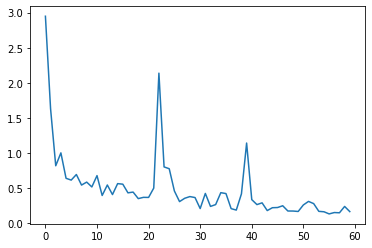

Epoch 1/100
11/11 - 4s - loss: 2.9076 - accuracy: 0.4195 - auc_71: 0.6270 - precision_71: 0.4386 - recall_71: 0.3799 - f1_score: 0.2986 - val_loss: 16.1126 - val_accuracy: 0.3784 - val_auc_71: 0.5338 - val_precision_71: 0.3784 - val_recall_71: 0.3784 - val_f1_score: 0.2035 - 4s/epoch - 371ms/step
Epoch 2/100
11/11 - 0s - loss: 1.0343 - accuracy: 0.4225 - auc_71: 0.6280 - precision_71: 0.4519 - recall_71: 0.3708 - f1_score: 0.3343 - val_loss: 12.2204 - val_accuracy: 0.3784 - val_auc_71: 0.5457 - val_precision_71: 0.3784 - val_recall_71: 0.3784 - val_f1_score: 0.1830 - 459ms/epoch - 42ms/step
Epoch 3/100
11/11 - 0s - loss: 0.9492 - accuracy: 0.5623 - auc_71: 0.7383 - precision_71: 0.5917 - recall_71: 0.5198 - f1_score: 0.4463 - val_loss: 14.1209 - val_accuracy: 0.3784 - val_auc_71: 0.5338 - val_precision_71: 0.3784 - val_recall_71: 0.3784 - val_f1_score: 0.1830 - 441ms/epoch - 40ms/step
Epoch 4/100
11/11 - 0s - loss: 0.6715 - accuracy: 0.5897 - auc_71: 0.7954 - precision_71: 0.5961 - rec

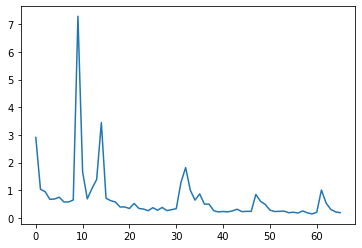

Epoch 1/100
11/11 - 4s - loss: 3.5409 - accuracy: 0.4164 - auc_72: 0.6447 - precision_72: 0.4143 - recall_72: 0.4043 - f1_score: 0.3104 - val_loss: 21.2585 - val_accuracy: 0.3784 - val_auc_72: 0.4467 - val_precision_72: 0.3784 - val_recall_72: 0.3784 - val_f1_score: 0.1944 - 4s/epoch - 363ms/step
Epoch 2/100
11/11 - 0s - loss: 3.5637 - accuracy: 0.3678 - auc_72: 0.5477 - precision_72: 0.3792 - recall_72: 0.3435 - f1_score: 0.2903 - val_loss: 14.0388 - val_accuracy: 0.0000e+00 - val_auc_72: 0.2703 - val_precision_72: 0.0000e+00 - val_recall_72: 0.0000e+00 - val_f1_score: 0.0000e+00 - 470ms/epoch - 43ms/step
Epoch 3/100
11/11 - 0s - loss: 0.9878 - accuracy: 0.4954 - auc_72: 0.6918 - precision_72: 0.4913 - recall_72: 0.4286 - f1_score: 0.3790 - val_loss: 4.6648 - val_accuracy: 0.5135 - val_auc_72: 0.6552 - val_precision_72: 0.5135 - val_recall_72: 0.5135 - val_f1_score: 0.2262 - 471ms/epoch - 43ms/step
Epoch 4/100
11/11 - 0s - loss: 0.6963 - accuracy: 0.5836 - auc_72: 0.8033 - precision_7

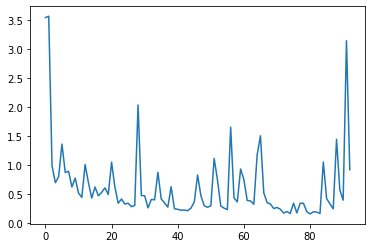

Epoch 1/100
11/11 - 4s - loss: 3.0411 - accuracy: 0.3891 - auc_73: 0.5806 - precision_73: 0.4097 - recall_73: 0.3587 - f1_score: 0.2845 - val_loss: 7.5482 - val_accuracy: 0.5676 - val_auc_73: 0.6757 - val_precision_73: 0.5676 - val_recall_73: 0.5676 - val_f1_score: 0.2414 - 4s/epoch - 365ms/step
Epoch 2/100
11/11 - 0s - loss: 1.8417 - accuracy: 0.3556 - auc_73: 0.5381 - precision_73: 0.3535 - recall_73: 0.3191 - f1_score: 0.2818 - val_loss: 24.8021 - val_accuracy: 0.0270 - val_auc_73: 0.2703 - val_precision_73: 0.0270 - val_recall_73: 0.0270 - val_f1_score: 0.0290 - 462ms/epoch - 42ms/step
Epoch 3/100
11/11 - 0s - loss: 0.7988 - accuracy: 0.5046 - auc_73: 0.7212 - precision_73: 0.5194 - recall_73: 0.4468 - f1_score: 0.3864 - val_loss: 2.7159 - val_accuracy: 0.4595 - val_auc_73: 0.6927 - val_precision_73: 0.4595 - val_recall_73: 0.4595 - val_f1_score: 0.2556 - 471ms/epoch - 43ms/step
Epoch 4/100
11/11 - 0s - loss: 0.7604 - accuracy: 0.5623 - auc_73: 0.7828 - precision_73: 0.5777 - recal

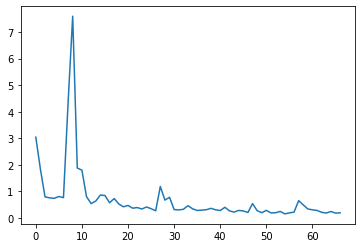

Epoch 1/100
11/11 - 4s - loss: 3.0202 - accuracy: 0.4772 - auc_74: 0.6632 - precision_74: 0.4688 - recall_74: 0.4559 - f1_score: 0.3195 - val_loss: 9.6221 - val_accuracy: 0.2432 - val_auc_74: 0.4238 - val_precision_74: 0.2432 - val_recall_74: 0.2432 - val_f1_score: 0.1429 - 4s/epoch - 378ms/step
Epoch 2/100
11/11 - 0s - loss: 1.0684 - accuracy: 0.4863 - auc_74: 0.6925 - precision_74: 0.4965 - recall_74: 0.4316 - f1_score: 0.3538 - val_loss: 12.1092 - val_accuracy: 0.5405 - val_auc_74: 0.6554 - val_precision_74: 0.5405 - val_recall_74: 0.5405 - val_f1_score: 0.2339 - 454ms/epoch - 41ms/step
Epoch 3/100
11/11 - 0s - loss: 2.3507 - accuracy: 0.5228 - auc_74: 0.7285 - precision_74: 0.5208 - recall_74: 0.4954 - f1_score: 0.3688 - val_loss: 8.6686 - val_accuracy: 0.4054 - val_auc_74: 0.5517 - val_precision_74: 0.4054 - val_recall_74: 0.4054 - val_f1_score: 0.2041 - 472ms/epoch - 43ms/step
Epoch 4/100
11/11 - 0s - loss: 1.0003 - accuracy: 0.5076 - auc_74: 0.7065 - precision_74: 0.5177 - recal

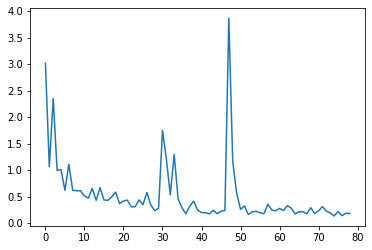

Epoch 1/100
11/11 - 4s - loss: 4.4083 - accuracy: 0.3617 - auc_75: 0.5170 - precision_75: 0.3559 - recall_75: 0.3191 - f1_score: 0.2797 - val_loss: 18.4020 - val_accuracy: 0.0000e+00 - val_auc_75: 0.2763 - val_precision_75: 0.0000e+00 - val_recall_75: 0.0000e+00 - val_f1_score: 0.0000e+00 - 4s/epoch - 394ms/step
Epoch 2/100
11/11 - 0s - loss: 1.7484 - accuracy: 0.4559 - auc_75: 0.6257 - precision_75: 0.4480 - recall_75: 0.3799 - f1_score: 0.3431 - val_loss: 34.8868 - val_accuracy: 0.0000e+00 - val_auc_75: 0.2500 - val_precision_75: 0.0000e+00 - val_recall_75: 0.0000e+00 - val_f1_score: 0.0000e+00 - 461ms/epoch - 42ms/step
Epoch 3/100
11/11 - 0s - loss: 1.8848 - accuracy: 0.4347 - auc_75: 0.6043 - precision_75: 0.4384 - recall_75: 0.3678 - f1_score: 0.3353 - val_loss: 4.5406 - val_accuracy: 0.4054 - val_auc_75: 0.5002 - val_precision_75: 0.4054 - val_recall_75: 0.4054 - val_f1_score: 0.2339 - 467ms/epoch - 42ms/step
Epoch 4/100
11/11 - 0s - loss: 0.7153 - accuracy: 0.6140 - auc_75: 0.80

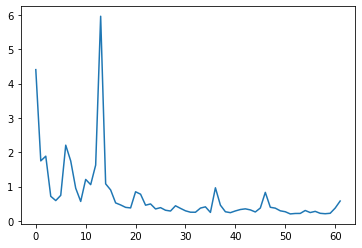

Epoch 1/100
11/11 - 4s - loss: 2.9381 - accuracy: 0.3697 - auc_76: 0.5560 - precision_76: 0.3611 - recall_76: 0.3152 - f1_score: 0.2748 - val_loss: 1.0707 - val_accuracy: 0.5833 - val_auc_76: 0.7897 - val_precision_76: 0.5833 - val_recall_76: 0.5833 - val_f1_score: 0.3780 - 4s/epoch - 371ms/step
Epoch 2/100
11/11 - 0s - loss: 1.5186 - accuracy: 0.4818 - auc_76: 0.6772 - precision_76: 0.4982 - recall_76: 0.4303 - f1_score: 0.3324 - val_loss: 51.1762 - val_accuracy: 0.0278 - val_auc_76: 0.2708 - val_precision_76: 0.0278 - val_recall_76: 0.0278 - val_f1_score: 0.0417 - 454ms/epoch - 41ms/step
Epoch 3/100
11/11 - 0s - loss: 1.1354 - accuracy: 0.4364 - auc_76: 0.6256 - precision_76: 0.4638 - recall_76: 0.3879 - f1_score: 0.3469 - val_loss: 13.6057 - val_accuracy: 0.0278 - val_auc_76: 0.2432 - val_precision_76: 0.0278 - val_recall_76: 0.0278 - val_f1_score: 0.0417 - 441ms/epoch - 40ms/step
Epoch 4/100
11/11 - 0s - loss: 0.9734 - accuracy: 0.4970 - auc_76: 0.7061 - precision_76: 0.5017 - reca

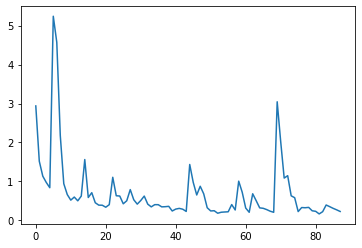

Epoch 1/100
11/11 - 4s - loss: 3.5386 - accuracy: 0.4697 - auc_77: 0.6729 - precision_77: 0.4774 - recall_77: 0.4485 - f1_score: 0.3228 - val_loss: 18.0115 - val_accuracy: 0.0833 - val_auc_77: 0.3796 - val_precision_77: 0.0833 - val_recall_77: 0.0833 - val_f1_score: 0.0690 - 4s/epoch - 365ms/step
Epoch 2/100
11/11 - 0s - loss: 2.4564 - accuracy: 0.2515 - auc_77: 0.4276 - precision_77: 0.2610 - recall_77: 0.2333 - f1_score: 0.2259 - val_loss: 10.2779 - val_accuracy: 0.3611 - val_auc_77: 0.5208 - val_precision_77: 0.3611 - val_recall_77: 0.3611 - val_f1_score: 0.1769 - 472ms/epoch - 43ms/step
Epoch 3/100
11/11 - 0s - loss: 0.9318 - accuracy: 0.5515 - auc_77: 0.7472 - precision_77: 0.5678 - recall_77: 0.4697 - f1_score: 0.4193 - val_loss: 20.2637 - val_accuracy: 0.0833 - val_auc_77: 0.3167 - val_precision_77: 0.0833 - val_recall_77: 0.0833 - val_f1_score: 0.0769 - 453ms/epoch - 41ms/step
Epoch 4/100
11/11 - 0s - loss: 2.0072 - accuracy: 0.3879 - auc_77: 0.5766 - precision_77: 0.3974 - rec

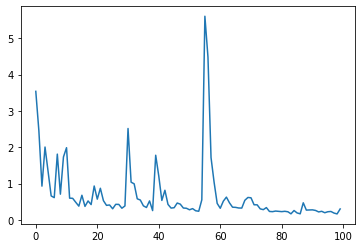

Epoch 1/100
11/11 - 4s - loss: 2.7757 - accuracy: 0.3909 - auc_78: 0.5826 - precision_78: 0.3911 - recall_78: 0.3212 - f1_score: 0.2782 - val_loss: 17.1305 - val_accuracy: 0.4167 - val_auc_78: 0.5625 - val_precision_78: 0.4167 - val_recall_78: 0.4167 - val_f1_score: 0.2208 - 4s/epoch - 360ms/step
Epoch 2/100
11/11 - 0s - loss: 1.4266 - accuracy: 0.4788 - auc_78: 0.6727 - precision_78: 0.4899 - recall_78: 0.4394 - f1_score: 0.3386 - val_loss: 26.5680 - val_accuracy: 0.0278 - val_auc_78: 0.2708 - val_precision_78: 0.0278 - val_recall_78: 0.0278 - val_f1_score: 0.0185 - 447ms/epoch - 41ms/step
Epoch 3/100
11/11 - 0s - loss: 3.4004 - accuracy: 0.4212 - auc_78: 0.6096 - precision_78: 0.4219 - recall_78: 0.3848 - f1_score: 0.3042 - val_loss: 13.8414 - val_accuracy: 0.0278 - val_auc_78: 0.2863 - val_precision_78: 0.0278 - val_recall_78: 0.0278 - val_f1_score: 0.0185 - 453ms/epoch - 41ms/step
Epoch 4/100
11/11 - 0s - loss: 0.6819 - accuracy: 0.5970 - auc_78: 0.7916 - precision_78: 0.6057 - rec

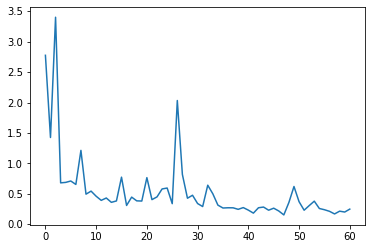

Epoch 1/100
11/11 - 4s - loss: 2.2970 - accuracy: 0.4030 - auc_79: 0.6080 - precision_79: 0.4192 - recall_79: 0.3697 - f1_score: 0.3047 - val_loss: 5.4277 - val_accuracy: 0.1111 - val_auc_79: 0.3098 - val_precision_79: 0.1212 - val_recall_79: 0.1111 - val_f1_score: 0.1187 - 4s/epoch - 361ms/step
Epoch 2/100
11/11 - 0s - loss: 4.1467 - accuracy: 0.3515 - auc_79: 0.5181 - precision_79: 0.3522 - recall_79: 0.3394 - f1_score: 0.2820 - val_loss: 8.3126 - val_accuracy: 0.1389 - val_auc_79: 0.3295 - val_precision_79: 0.1389 - val_recall_79: 0.1389 - val_f1_score: 0.1190 - 456ms/epoch - 41ms/step
Epoch 3/100
11/11 - 0s - loss: 1.0049 - accuracy: 0.5394 - auc_79: 0.7356 - precision_79: 0.5340 - recall_79: 0.5000 - f1_score: 0.4144 - val_loss: 11.2510 - val_accuracy: 0.6389 - val_auc_79: 0.7292 - val_precision_79: 0.6389 - val_recall_79: 0.6389 - val_f1_score: 0.2599 - 459ms/epoch - 42ms/step
Epoch 4/100
11/11 - 0s - loss: 0.8257 - accuracy: 0.5333 - auc_79: 0.7551 - precision_79: 0.5467 - recal

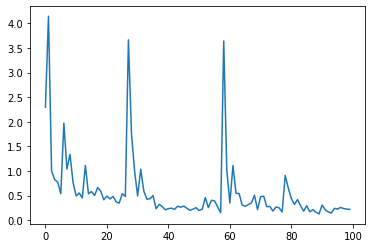

In [78]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []
val_accuracy = 0.0
for train_index, val_index in kf.split(body_X):
    body_X_train, body_X_val = body_X[train_index], body_X[val_index]
    face_X_train, face_X_val = face_X[train_index], face_X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    rcnn_intensity_latefusion_model = RCNN_fusioned(body_features, face_features, n_length, n_outputs, multiclass=True)
    history = rcnn_intensity_latefusion_model.train(body_X_train, face_X_train, y_train, body_X_val, face_X_val, y_val, epochs=epochs, batch_size=32, class_weight=d_class_weights)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        rcnn_intensity_latefusion_model.save(model_path / 'late_intensity_rcnn.h5')

#### Training performance and variance

In [79]:
late_rcnn_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
late_rcnn_train_results

{'Accuracy': 0.8998074948787689,
 'ROC/AUC': 0.9698138535022736,
 'Precision': 0.9000697493553161,
 'Recall': 0.8998074948787689,
 'F1-score': 0.8286823332309723}

In [80]:
late_rcnn_train_var = {'Accuracy': np.var(acc), 'ROC/AUC': np.var(auc), 'Precision': np.var(precision), 'Recall': np.var(recall), 'F1-score': np.var(f1)}
late_rcnn_train_var

{'Accuracy': 0.001383497596314989,
 'ROC/AUC': 0.00039387438274847143,
 'Precision': 0.001363332847084706,
 'Recall': 0.001383497596314989,
 'F1-score': 0.006490643092301162}

#### Validation performance and variance

In [81]:
late_rcnn_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
late_rcnn_val_results

{'Accuracy': 0.6180180251598358,
 'ROC/AUC': 0.8139799356460571,
 'Precision': 0.6180180251598358,
 'Recall': 0.6180180251598358,
 'F1-score': 0.3961446642875671}

In [82]:
late_rcnn_val_var = {'Accuracy': np.var(acc_val), 'ROC/AUC': np.var(auc_val), 'Precision': np.var(precision_val), 'Recall': np.var(recall_val), 'F1-score': np.var(f1_val)}
late_rcnn_val_var

{'Accuracy': 0.007642303593546594,
 'ROC/AUC': 0.0028700731565534454,
 'Precision': 0.007642303593546594,
 'Recall': 0.007642303593546594,
 'F1-score': 0.006077000322670542}

#### Predictions and performance on test set

In [83]:
rcnn_intensity_latefusion_model = load_model(model_path / 'late_intensity_rcnn.h5')
y_pred = rcnn_intensity_latefusion_model.predict([body_X_test, face_X_test])
_, acc, auc, precision, recall, f1 = rcnn_intensity_latefusion_model.evaluate([body_X_test, face_X_test], y_test)
rcnn_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

8/8 [==============================] - 1s 13ms/step - loss: 0.9928 - accuracy: 0.6623 - auc_76: 0.8561 - precision_76: 0.6652 - recall_76: 0.6450 - f1_score: 0.3575
Accuracy: 66.23% 
ROC/AUC: 0.86 
Precision: 0.67 
Recall: 0.65 
F1 score: 0.36


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

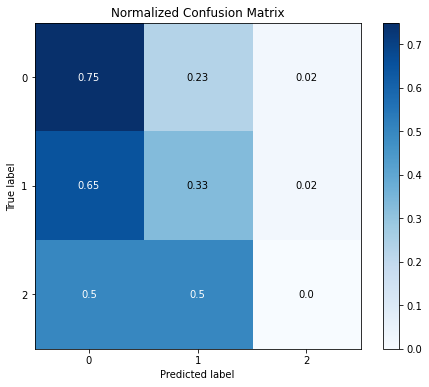

In [84]:
skplt.metrics.plot_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize=True, figsize=(8,6))

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

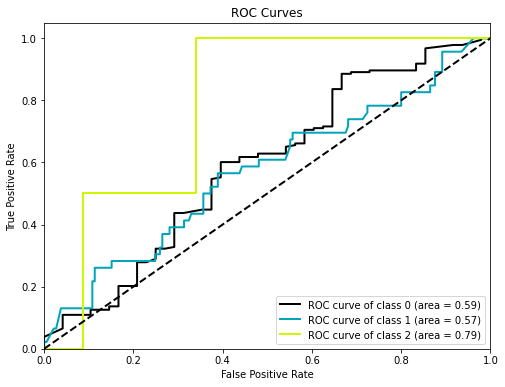

In [85]:
skplt.metrics.plot_roc(y_test.argmax(axis=1), y_pred, plot_micro=False, plot_macro=False, figsize=(8,6))

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

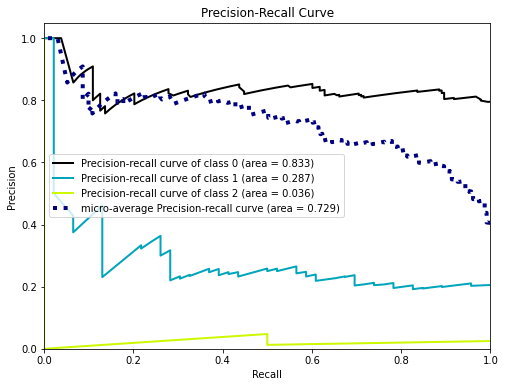

In [86]:
skplt.metrics.plot_precision_recall_curve(y_test.argmax(axis=1), y_pred, figsize=(8,6))

### 4.3 Ensemble

In [87]:
cnnlstm_body_member = KerasMember(name="CNN + Bidirectional LSTM Body Model", keras_model=cnnlstm_intensity_body_model, train_batches=(body_X_train, y_train), val_batches=(body_X_test, body_y_test))
rcnn_body_member = KerasMember(name="RCNN Body Model", keras_model=rcnn_intensity_body_model, train_batches=(body_X_train, y_train), val_batches=(body_X_test, body_y_test))
cnnlstm_face_member = KerasMember(name="CNN + Bidirectional LSTM Face Model", keras_model=cnnlstm_intensity_face_model, train_batches=(face_X_train, y_train), val_batches=(face_X_test, face_y_test))
rcnn_face_member = KerasMember(name="RCNN Face Model", keras_model=rcnn_intensity_face_model, train_batches=(face_X_train, y_train), val_batches=(face_X_test, face_y_test))

In [88]:
dirichletEnsemble = DirichletEnsemble()
dirichletEnsemble.add_member(cnnlstm_body_member)
dirichletEnsemble.add_member(rcnn_body_member)
dirichletEnsemble.add_member(cnnlstm_face_member)
dirichletEnsemble.add_member(rcnn_face_member)
dirichletEnsemble.fit()

In [89]:
e = dirichletEnsemble.describe()
cnnlstm_auc.append(round(e, 2))
rcnn_auc.append(0)

CNN + Bidirectional LSTM Body Model (weight: 0.6704)
RCNN Body Model (weight: 0.0018)
CNN + Bidirectional LSTM Face Model (weight: 0.0100)
RCNN Face Model (weight: 0.3179)
Accuracy: 79.22% - ROC/AUC: 0.62 - Precision: 0.38 - Recall: 0.37 - F1 score: 0.37


## Results

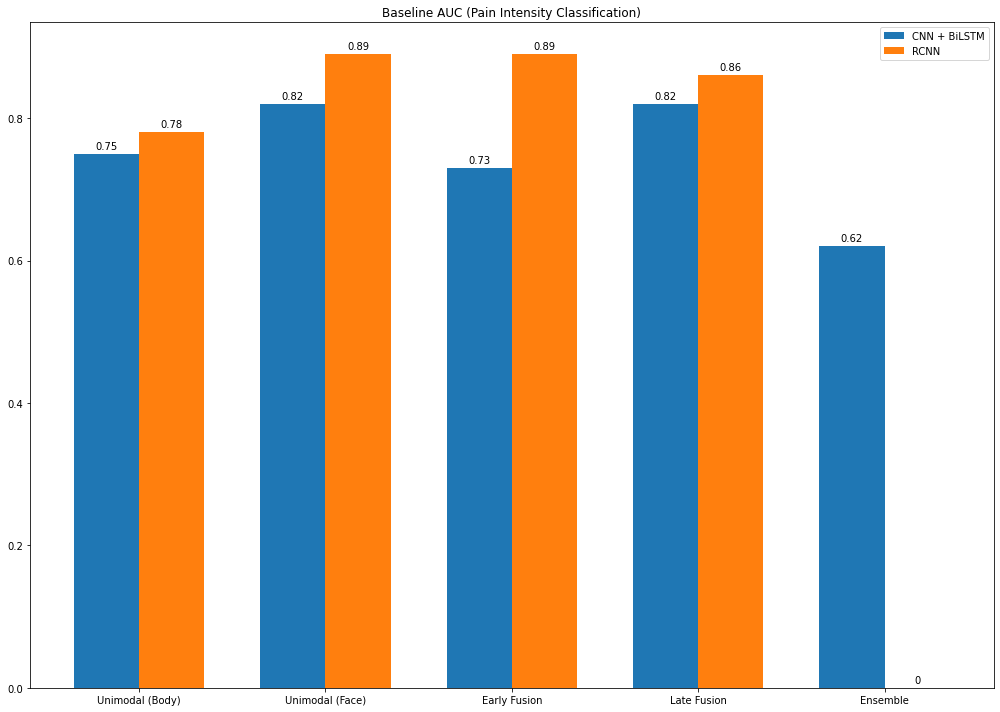

In [90]:
labels = ['Unimodal (Body)', 'Unimodal (Face)', 'Early Fusion', 'Late Fusion', 'Ensemble']

x = np.arange(len(labels)) 
width = 0.35 

fig, ax = plt.subplots(figsize=(14, 10))
rects1 = ax.bar(x - width/2, cnnlstm_auc, width, label='CNN + BiLSTM')
rects2 = ax.bar(x + width/2, rcnn_auc, width, label='RCNN')

ax.set_title('Baseline AUC (Pain Intensity Classification)')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()